# FANFICTION SENTIMENT AND EMOTION ANALYSIS

## Table of Contents
* [Introduction](#one)
* [Environment setup](#two)
* [Data setup](#three)
* [Exploratory analysis](#four)
* [Text representation](#five)
* [Sentiment analysis](#six)
    * [VADER](#6a)
    * [TextBlob](#6b)
    * [StanfordNLP](#6c)
* [Emotion analysis](#seven)
    * [NRC Emotion](#7a)
    * [NRC Intensity Emotion](#7b)
    * [VAD](#7c)
    * [Hashtag Emotion](#7d)
* [Genre classification](#eight)
    * [Logistic](#8a)
    * [SVM](#8b)
    * [KNN](#8c)
    * [Gaussian naive bayes](#8d)
    * [Neural net](#8e)
    * [XGBoost](#8f)
* [Conclusion](#nine)   

# <a class="anchor" id="one">Introduction </a>

In this notebook, we will be examining the sentiment and emotions of online fanfiction publications. 

Our working hypothesis is that the genre of a work is heavily encapsulated by its emotional content and tone. Therefore, if we can successfully decompose textual data into its representative emotions, we can then predict its genre. 

Our goal is two-fold. First, we would like to examine the sentimental and emotional composition of each genre. Second, we would like to see if we can predict the genre of a story based on its text and emotional composition.

# <a class="anchor" id="two">Environment setup </a>

In this section, we will set up our working environment.

### Import libaries

In [326]:
# imports utility libraries
import pandas as pd
import numpy as np
import pickle
import datetime
import string
import re
import multiprocessing
import warnings
from joblib import Parallel, delayed
from itertools import cycle
from IPython.core.display import display, HTML

# import scipi
from scipy import interp
from scipy.stats import chisquare

# import graphics
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
%matplotlib inline

# import sklearn tools
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import scale, label_binarize, Binarizer, Normalizer
from sklearn.manifold import TSNE
from sklearn import metrics, svm, datasets
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# import nltk tools
import nltk
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import xgboost
import xgboost as xgb

# import gensim tools
from gensim import corpora, models 
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# import textblob
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer

# stanford NLP
from pycorenlp import StanfordCoreNLP
stanford = StanfordCoreNLP('http://localhost:9000')

### Configure graphics

In [2]:
# configure graphics (taken from session notes)
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]
dark2_cmap = ListedColormap(dark2_colors)
def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'
mpl.rcParams.update(mpl.rcParamsDefault)
set_mpl_params()
mpl.style.use('ggplot')

### Import lexical dictionaries

In [3]:
# installs corpus
## nltk.download()
## nltk.download('punkt')
## nltk.download('vader_lexicon')
## nltk.download('movie_reviews')

# sets stop word list for text parsing
stop_words = stopwords.words('english')

# <a class="anchor" id="three">Data and function setup </a>

In this section, we will be importing the cleaned fanfiction data as well as the emotional lexicons.

The fanfiction data that we will use is scraped from the official [fanfiction.net](https://www.fanfiction.net/) site. We have downloaded a random sample of 5000 stories out of approximately 13 million. Of these 5000 stories, approximately half were both still existing (that is, not deleted) as well as written in English, which is the subset that we will be performing out analysis on.

The python scripts we created to scrape the data can be found [here](https://github.com/lily-tian/fanfictionstatistics).

Furthermore, for our emotion analysis, we have also downloaded and imported the [emotion lexicons](http://saifmohammad.com/) of Dr. Saif M. Mohammad, a Senior Research Scientist at the National Research Council Canada (NRC).

For the sake of readability, we have also placed all the functions we will be calling in this section. These functions include those for plotting/graphics, textual decomposition, clustering, and extracting passages/lines.

## Data setup

In [4]:
# opens cleaned data
with open ('../data/clean_data/df_story', 'rb') as fp:
    df = pickle.load(fp)
df = df.loc[(df.state == 'online') & (df.language == 'English'), ].copy()
df['title_summary'] = df['title'] + ' ' + df['summary']
df['main_genre'] = [g[0] for g in df.genre]
df.index = range(df.shape[0])

# opens features data
with open ('../data/clean_data/feature_data2', 'rb') as fp:
    feature_data = pickle.load(fp)

In [5]:
# opens emotion lexicon data
emolex = pd.read_csv("../data/nrc_emotion_data/nrc_emotion_lexicon.txt", sep="\t", header=None)
emolex.columns = ['term', 'emotion', 'is_emotion']

intlex = pd.read_csv("../data/nrc_emotion_data/nrc_affectintensity_lexicon.txt", sep="\t")
intlex.columns = ['term', 'score', 'emotion']

hashlex = pd.read_csv("../data/nrc_emotion_data/nrc_hashtag_emotion_lexicon.txt", sep="\t", header=None)
hashlex.columns = ['emotion', 'hashtag', 'score']
hashlex['hashtag'] = [re.sub('#+', '', str(h)) for h in hashlex.hashtag]

vadlex = pd.read_csv("../data/nrc_emotion_data/nrc_vad_lexicon.txt", sep="\t")
vadlex.columns = ['term', 'valence', 'arousal', 'dominance']

# define emotion lists
base_emotions = list(set(emolex.emotion))
intensity_emotions = list(set(intlex.emotion))
vad_emotions = ['valence', 'arousal', 'dominance']
hash_emotions = list(set(hashlex.emotion))

## Function setup

In [441]:
def plot_breakdown(x, title, r=90, hide=False):
    plt.rcParams['figure.figsize'] = [16, 3]
    plt.bar(range(len(x)), x)
    plt.xticks(range(len(x)), x.index, rotation=r)
    if hide:
        plt.tick_params(axis='x', bottom=False, labelbottom=False)
    plt.title(title)
    plt.show()

def plot_silhouette(x, y, title="Silhouette vs. k"):
    plt.rcParams['figure.figsize'] = [16, 2]    
    plt.plot(x, y)
    plt.scatter(x, y)
    plt.title(title)
    plt.show()
    
# plot t-sne scatter with colored groups 
def plot_representation(matrix, group, title, alpha=0.5):
    tsne_model = TSNE(n_components=2)
    tsne_matrix = tsne_model.fit_transform(matrix)
    tsne_df = pd.DataFrame(tsne_matrix)
    tsne_df.columns = ["Dimension 1", "Dimension 2"]
    tsne_df['group'] = group
    fig = sns.lmplot('Dimension 1', 'Dimension 2', 
                     data=tsne_df, hue="group", fit_reg=False, 
                     scatter_kws={'alpha':0.5}, legend=False)
    fig.fig.set_size_inches(16, 9)
    plt.title(title)
    plt.legend(loc='right', ncol=1)
    plt.show()
    
# plot by play and act-scene
def plot_scenes(data, group, outlier=False):
    data = data.copy()
    data.columns = ['label', 'y', 'x']
    data['group'] = group
    data['counts'] = data.shape[0] / data['group'].map(data['group'].value_counts())
    data['counts'] = (data['counts'] / np.max(data['counts'])) * 100
    if outlier:
        data['counts'] = [100 if g==-1 else 30 for g in group]
    plt.rcParams['figure.figsize'] = [16, 12]    
    plt.scatter(data['x'], data['y'], s=data['counts'], c=data['group'], cmap=plt.get_cmap('tab20'))
    plt.yticks(range(len(sorted(list(set(data['label']))))), sorted(list(set(data['label']))))
    plt.xticks([])
    plt.ylabel('')
    plt.xlabel('')
    plt.show()

def plot_emotions(header, emotions):
    plot_vars = ['main_genre'] + [header + e for e in emotions]    
    plot_data = feature_data[plot_vars].groupby("main_genre").agg(sum)
    plot_data['genre_counts'] = plot_data.index
    plot_data['genre_counts'] = plot_data['genre_counts'].map(df['main_genre'].value_counts())
    plot_data = plot_data.div(plot_data.sum(axis=1), axis=0) # normalize by genre
    plot_data = plot_data.div(plot_data.sum(axis=0), axis=1) # normalize by emotion
    plot_data = plot_data.subtract(plot_data.mean(axis=0), axis=1) # take deviation from mean
    for emo in emotions:
        fig, ax = plt.subplots(figsize=(16, 3))
        plt.bar(plot_data.index, plot_data[header + emo])
        plt.xticks(range(len(plot_data.index)),plot_data.index)
        plt.title(emo)
        plt.xticks(rotation=90)
        plt.show()
        
# create custom tokenizer without stemmer
def base_tokenize(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text) 
    tokens = [t.lower() for t in tokens if t.lower() not in stop_words]
    return tokens

# create custom tokenizer that includes stemmer
def simple_tokenize(text):
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = SnowballStemmer('english')
    tokens = tokenizer.tokenize(text) 
    tokens = [t.lower() for t in tokens if t.lower() not in stop_words]
    return tokens

# create custom tokenizer that includes stemmer
def custom_tokenize(text):
    tokenizer = RegexpTokenizer(r'\w+')
    stemmer = SnowballStemmer('english')
    tokens = tokenizer.tokenize(text) 
    tokens = [stemmer.stem(w) for w in tokens]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [t for t in tokens if len(t) > 1]
    return tokens

# turn bodies of text into word count vectors
def get_word_count(vectorizer, text):
    count = vectorizer.fit_transform(text)
    count = pd.DataFrame(count.toarray())
    count.columns = vectorizer.get_feature_names()
    return count

# get the top words across all observations
def get_top_words(count, n_top):
    total_count = np.sum(count, axis=0)
    sorted_index = np.flip(np.argsort(total_count), axis=0)
    sorted_index = np.array(sorted_index[0:n_top])
    top_words = np.array(count.columns)[sorted_index]
    top_words_count = np.array(total_count)[sorted_index]
    return top_words, top_words_count

def get_pca(x, n=100):
    pca_model = PCA(n_components=n, random_state=0)
    pca_matrix = pca_model.fit_transform(scale(x))
    print("Explained variance: ", np.sum(pca_model.explained_variance_ratio_))
    return pca_matrix

def get_lsa(x, n=100):
    lsa_model = TruncatedSVD(n_components=n)
    doc_matrix = lsa_model.fit_transform(x)
    term_matrix = lsa_model.components_
    topic_matrix = np.diag(lsa_model.singular_values_)
    print("Explained variance: ", np.sum(lsa_model.explained_variance_ratio_))
    return doc_matrix, term_matrix, topic_matrix

def get_doc2vec(x, n=25):
    d2v_model = Doc2Vec(vector_size=n, min_count=1, window=5, workers=7, dm=1)
    d2v_model.build_vocab(x)
    d2v_model.train(x, total_examples=d2v_model.corpus_count, epochs=10)
    
    return d2v_model

def plot_ROC(y_test, y_pred, n_classes=20):
    
    # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # average and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC')
    plt.legend(loc="lower right")
    plt.show()

# <a class="anchor" id="four">Exploratory analysis</a>

In this section, we will perform some exploratory data analysis on the fanfiction data.

In [7]:
df_vars = ['storyid', 'title', 'summary', 'fandom', 'rated', 'words', 'main_genre']
df[df_vars].head()

,storyid,title,summary,fandom,rated,words,main_genre
0,2062,Of the One Who Is Foretold,Fic: A stranger comes to the Animorphs seeking...,Animorphs,K+,7672.0,General
1,19673,A Healer's Touch,"Left near dead, two Jedi are found by local he...",Star Wars,K+,16870.0,Drama
2,34152,R a i n (I'm getting sick of the new girl titles),basically from Gaia's P.O.V.,Harry Potter,K+,555.0,Adventure
3,40969,Scattered Thoughts of a Comatose Civilian Pilot,It's been brought to my attention that it's ob...,Gundam Wing/AC,K,212.0,Poetry
4,47543,"Enter The People's Girl, Part 5",The Rock finds Angelina...and is shocked,Wrestling,T,1457.0,General


In [8]:
print('Number of observations: ', df.shape[0])

Number of observations:  2525


## Word count and chapter length

Let's take a look at the distribution of word lengths.

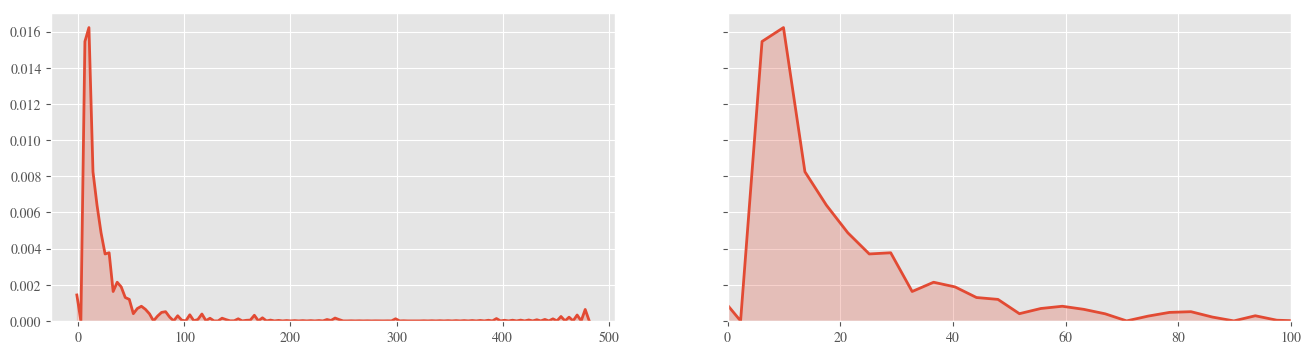

In [9]:
# examines distribution of number of words
df['words1k'] = df['words']/1000

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 4))
sns.kdeplot(df['words1k'], shade=True, bw=.5, legend=False, ax=ax1)
sns.kdeplot(df['words1k'], shade=True, bw=.5, legend=False, ax=ax2)
plt.xlim(0,100)
plt.show()

The bulk of stories appear to be less than 50 thousand words, with a high proportion between 0-20 thousand words. In other words, we have a significant proportion of short stories and novelettes, and some novellas. Novels become more rare. Finally, there are a few "epics", ranging from 200 thousand to 600 thousand words.

Working with texts on the magnitude of thousands is too computationally intensive and may not provide much additional information needed for our purposes. As such, we will primarily be using the title and summaries as a proxy for the content of the stories instead.

## Titles and summaries

How long are titles and summaries? Is there a systematic way authors write them? Do some words appear more often than others? Here we explore some of those questions.

Let's start by examining character and word count, respectively, for titles.

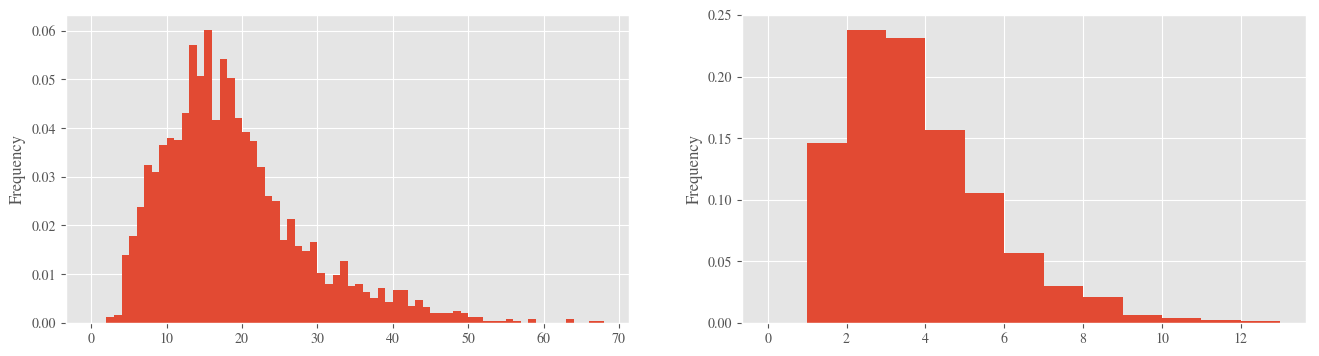

In [10]:
# examines word/character count of titles
title_cc = [len(row) for row in df['title']]
title_wc = [len(row.split()) for row in df['title']]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
pd.Series(title_cc).plot.hist(density=True, bins=np.arange(0, max(title_cc), 1), ax=ax1)
pd.Series(title_wc).plot.hist(density=True, bins=np.arange(0, max(title_wc), 1), ax=ax2)

plt.show()

Almost identical in shape of distribution. It would appear stories typically have 2-3 words in the title, or 15-20 characters.

Now let's look at summaries.

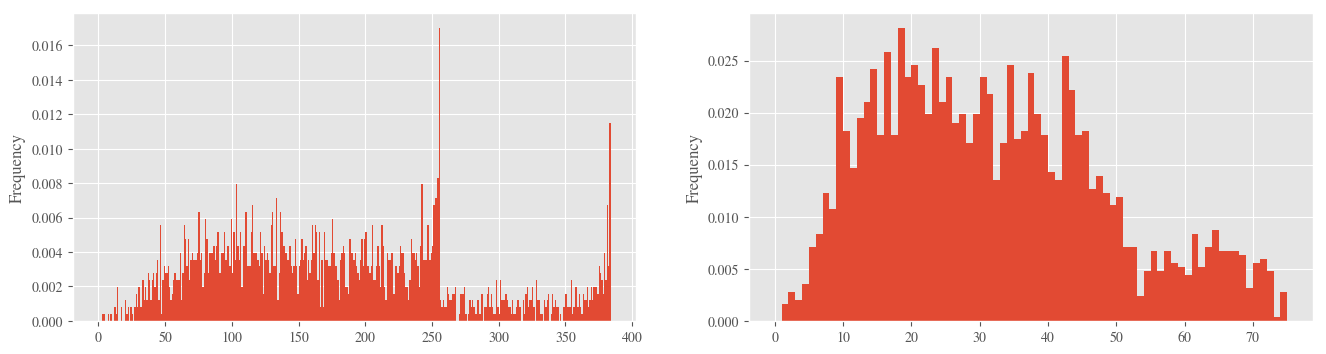

In [11]:
# examines word/character count of summaries
summary_cc = [len(row) for row in df['summary']]
summary_wc = [len(row.split()) for row in df['summary']]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
pd.Series(summary_cc).plot.hist(density=True, bins=np.arange(0, max(summary_cc), 1), ax=ax1)
pd.Series(summary_wc).plot.hist(density=True, bins=np.arange(0, max(summary_wc), 1), ax=ax2)

plt.show()

Again, similar shapes. Note the spike at 255 for the character count; this is a vestige of the original 255 character limit for summaries imposed by the site. Overall, it would appear summary lengths are pretty well dispersed.

Examining the most frequent words:

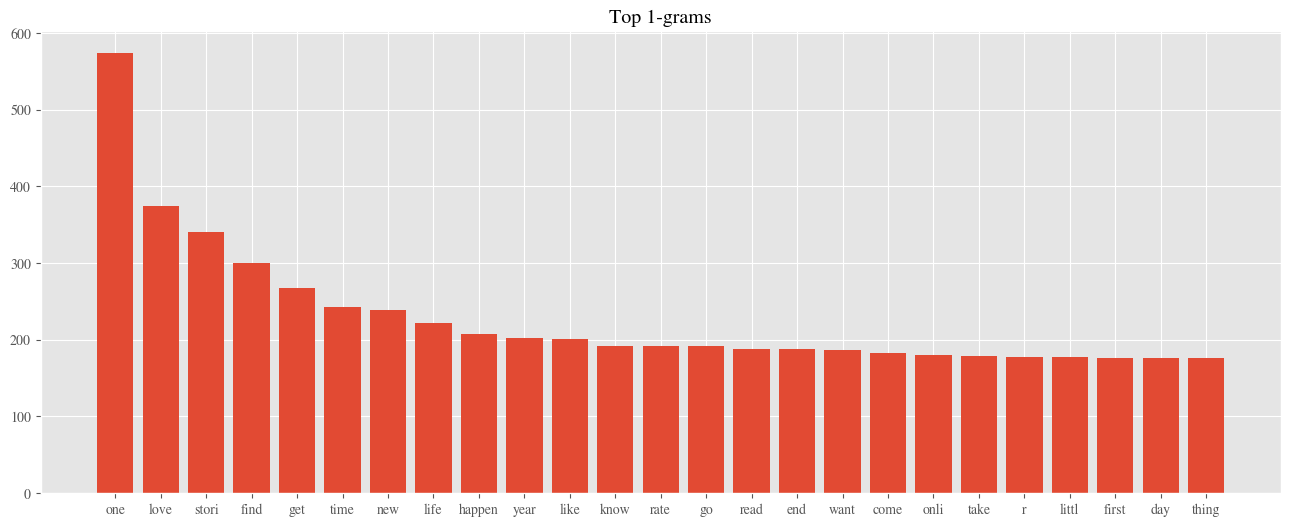

In [12]:
# get grams of text
onegram_vectorizer = CountVectorizer(tokenizer=custom_tokenize,
                                     ngram_range=(1,1),
                                     max_features=50)
text_onegram = get_word_count(onegram_vectorizer, df.title_summary)

# get top words
top_words, top_wc = get_top_words(text_onegram, n_top=25)

# plot top words
fig, ax = plt.subplots(figsize=(16, 6))
plt.bar(top_words,top_wc)
plt.xticks(range(len(top_words)),top_words)
plt.title("Top 1-grams")
plt.show()

## Genre distributions

Now let's look at the distribution of genres across the stories. Note that "General" includes stories that do not have a genre label.

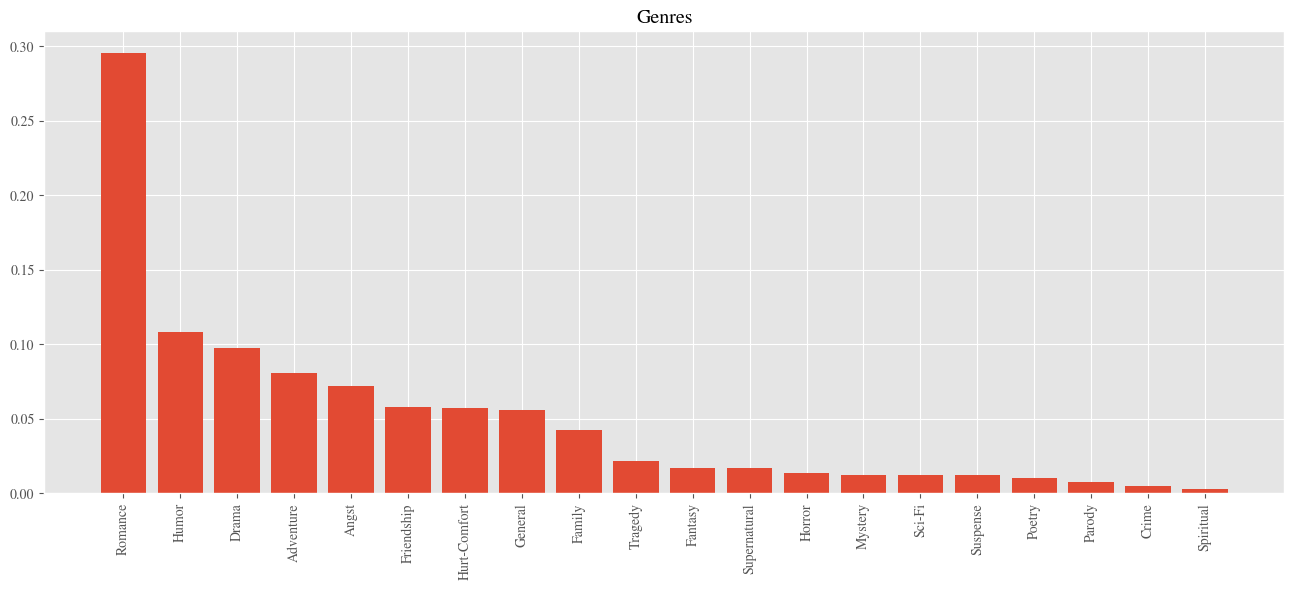

In [13]:
# examines top genres individually
genres_indiv = [item for sublist in df['genre'] for item in sublist]
genres_indiv = pd.Series(genres_indiv).value_counts()
genres_indiv = genres_indiv / np.sum(genres_indiv)

# plot top words
fig, ax = plt.subplots(figsize=(16, 6))
plt.bar(genres_indiv.index, genres_indiv.values)
plt.xticks(range(len(genres_indiv.index)), genres_indiv.index)
plt.title("Genres")
plt.xticks(rotation=90)
plt.show()

We can see that romance takes the lead! In fact, ~30% of the genre labels used is romance. In second and third place are humor and drama respectively.

The least popular genres appear to be parody, crime, and spirtual.

This disproportionate distribution of genres should note this when we later build our classifiers, as this will be our target variable.

Since stories fall under more than one genre category, let us also see how the genres combine.

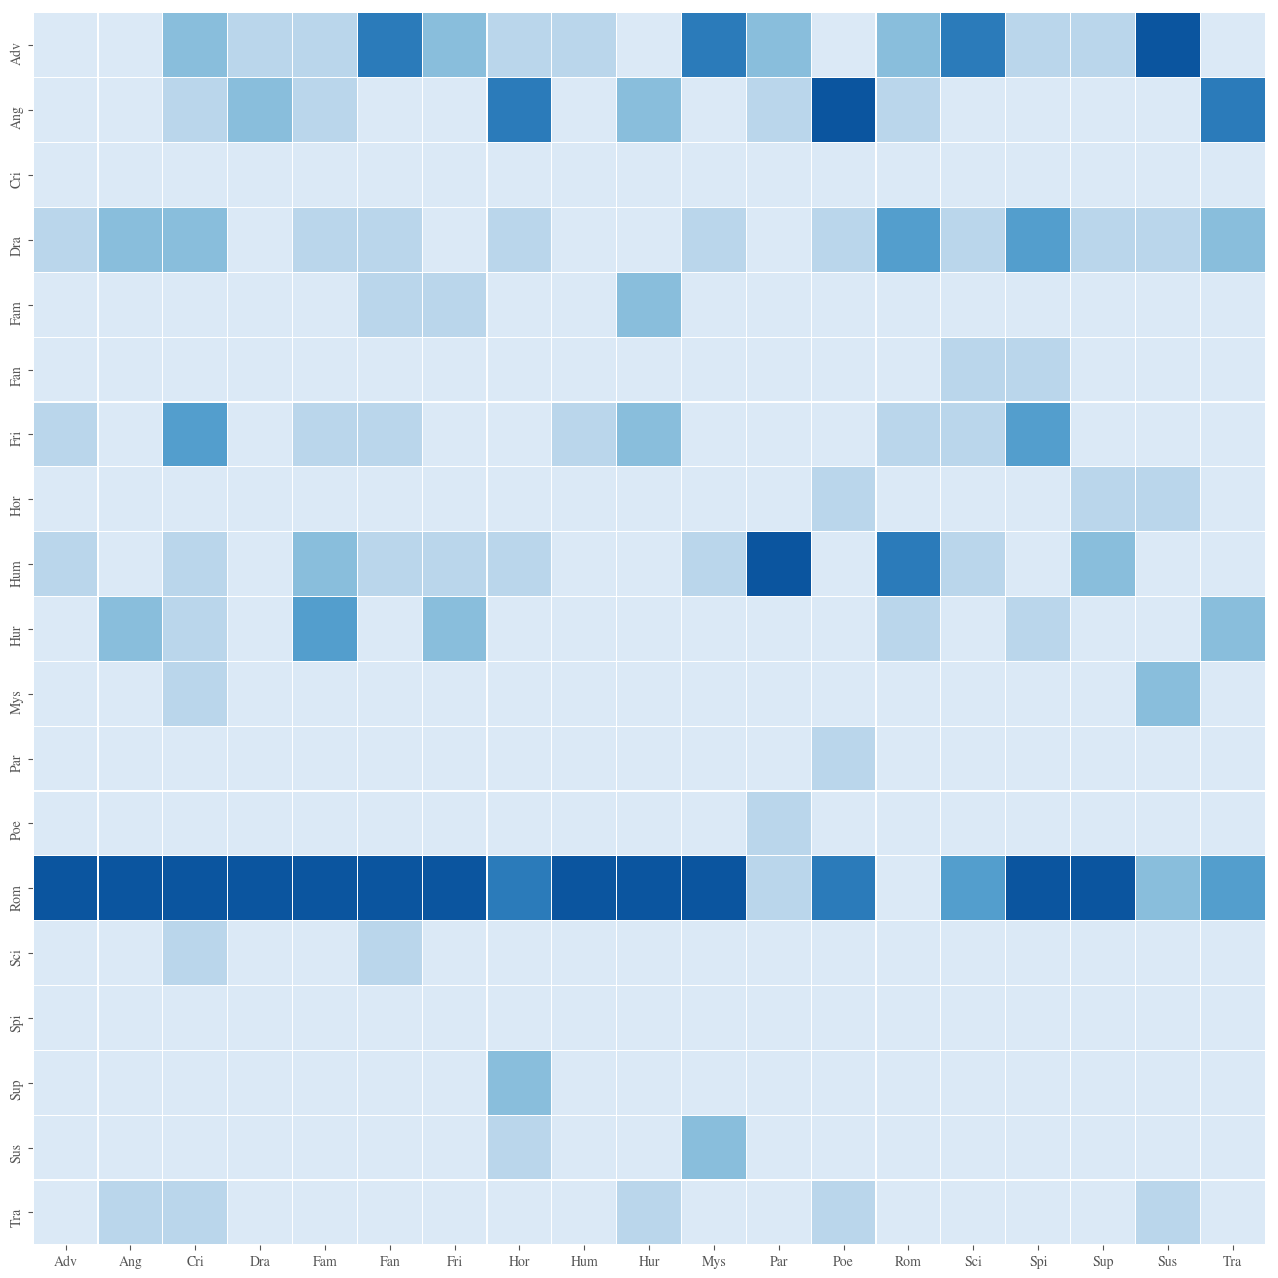

In [14]:
# creates contingency table
gen_pairs = df.loc[[len(row) > 1 for row in df.genre], 'genre']
gen1 = pd.Series([row[0][:3] for row in gen_pairs] + [row[1][:3] for row in gen_pairs])
gen2 = pd.Series([row[1][:3] for row in gen_pairs] + [row[0][:3] for row in gen_pairs])
cross = pd.crosstab(index=gen1, columns=gen2, colnames=[''])
del cross.index.name

# finds relative frequency
for col in cross.columns.values:
    cross[col] = cross[col]/np.sum(cross[col])
    
# plots heatmap
f, ax = plt.subplots(figsize=(16, 16))
cm = sns.color_palette("Blues")
ax = sns.heatmap(cross, cmap=cm, cbar=False, robust=True,
                 square=True, linewidths=0.1, linecolor='white')

plt.show()

In terms of how genres cross, romance appears to pair with almost everything. Romance is particularly common with drama (the romantic drama) and humor (the rom-com). The only genre that shies away from romance is parody, which goes in hand with humor instead. 

The second most crossed genre is adventure, which is often combined with fantasy, sci-fi, mystery, or suspense. 

The third genre to note is angst, which is often combined with horror, poetry, or tragedy.

Finally, we would like to examine some of the most important words within each genre. This is done though TF-IDF. Words are processed and cleaned, with captalization and punctuation removed. Stop words are also removed. Finally, the words are stemmed with the Snowball stemmer (also known as the Porter 2), which is an improved and slightly more aggressive version of the commonly used Porter stemmer.

In [442]:
# create vectorizers that converts text to weighted ngrams
get_tfidf = TfidfVectorizer(
    tokenizer=custom_tokenize,
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w+',
    ngram_range=(1,2),
    max_features=1000)

# get all weighted one and two grams of titles
text_tfidf = get_word_count(get_tfidf, df.title_summary)

In [443]:
for g in set(df.main_genre):
    tfidf_count = text_tfidf.loc[df.main_genre==g].mean(axis=0)
    top_words = np.flip(np.argsort(tfidf_count.values), axis=0)[:5]
    print(g, ':', ', '.join(tfidf_count.index[top_words]))

Mystery : dark, mysteri, one, killer, onli
Tragedy : die, one, death, happen, one shot
Friendship : friendship, one, shot, one shot, name
Horror : evil, death, happen, way, warn
Drama : one, stori, find, life, end
Parody : parodi, charact, hogwart, vs, random
Hurt-Comfort : never, left, one, oneshot, want
Spiritual : much, haunt, know, hear, tri
Crime : fairi, work, saw, chapter, castl
Family : brother, famili, one, kid, stori
Fantasy : stori, god, use, tale, pokemon
Romance : love, one, stori, get, happen
Suspense : vs, team, get, one, nation
Adventure : world, new, find, one, stori
Supernatural : vampir, life, dean, au, dark
Sci-Fi : war, end, stori, forev, charact
Angst : one, life, like, end, warn
General : one, drabbl, new, day, year
Poetry : poem, wrote, pleas, read, eye
Humor : get, one, find, stori, day


# <a class="anchor" id="five">Text representation</a>

As we can see from above, different genres seem to have different distribution of words, and also presumably topics. Since we will be building a classifier for genre, it may make sense to include the topics of the text as potential features.

In this section, we will create features through two different methods. 

The first is through Latent Semantic Analysis, which will represent each text as a vector of features. Each feature is then a linear combination of the ngrams in the corpus.

The second is through Doc2Vec.

## Topic representation with LSA

In [444]:
n_lsa = 50
lsa_docm_text, lsa_termm_text, lsa_topicm_text = get_lsa(text_tfidf, n=n_lsa)

Explained variance:  0.1877574009407121


With the LSA, we have captured approximately 19 percent of the information of the TF-IDF matrix within 50 aggregate features.

As a form of visualization, we further reduced our 50 features into two dimensions with t-SNE and plotted each story. The observations are then colored according to the genre it belongs to. As seen below, while there appears to be clear clusters in the stories, they are not necessarily separated by genre.

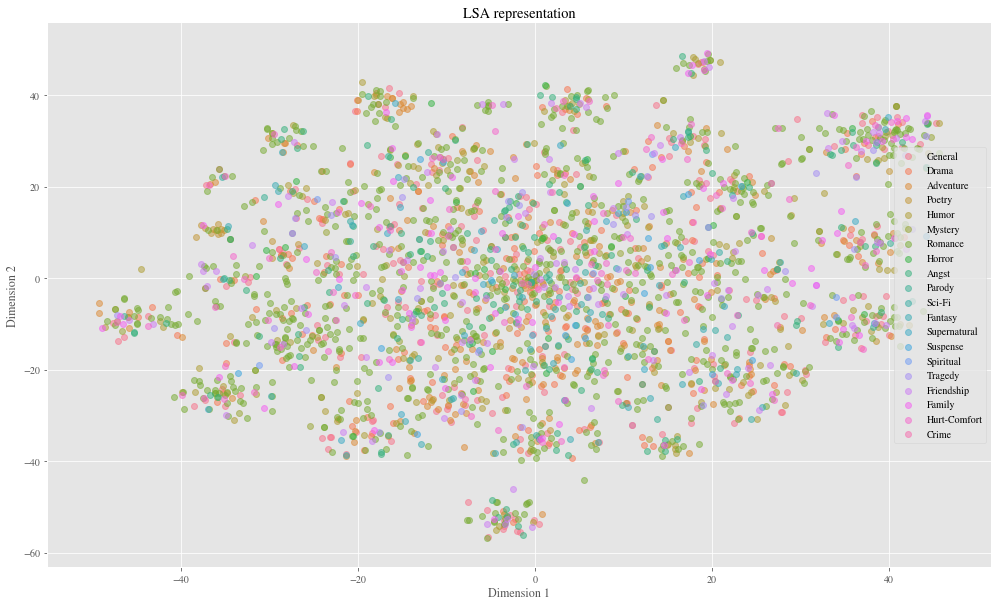

In [445]:
plot_representation(lsa_docm_text, df['main_genre'], 'LSA representation')

## Vector representation with Doc2Vec

Now we will switch over to vector representations using Doc2Vec. Unlike with the bag of words methods, the order of appearance in the words now matter, which hopefully captures some stylistic writing choices. We will be using a window of 5 and taking a vector length of 20.

In [225]:
tagged_text = [TaggedDocument(words=custom_tokenize(t), tags=[str(i)]) 
                for i, t in enumerate(df.title_summary)]

n_d2v = 20
d2v_text = get_doc2vec(tagged_text, n_d2v)

d2v_docm_text = d2v_text.docvecs.vectors_docs

From the plot below, we can see that our vector representation shows no discernable pattern between the extracted content and the genre.

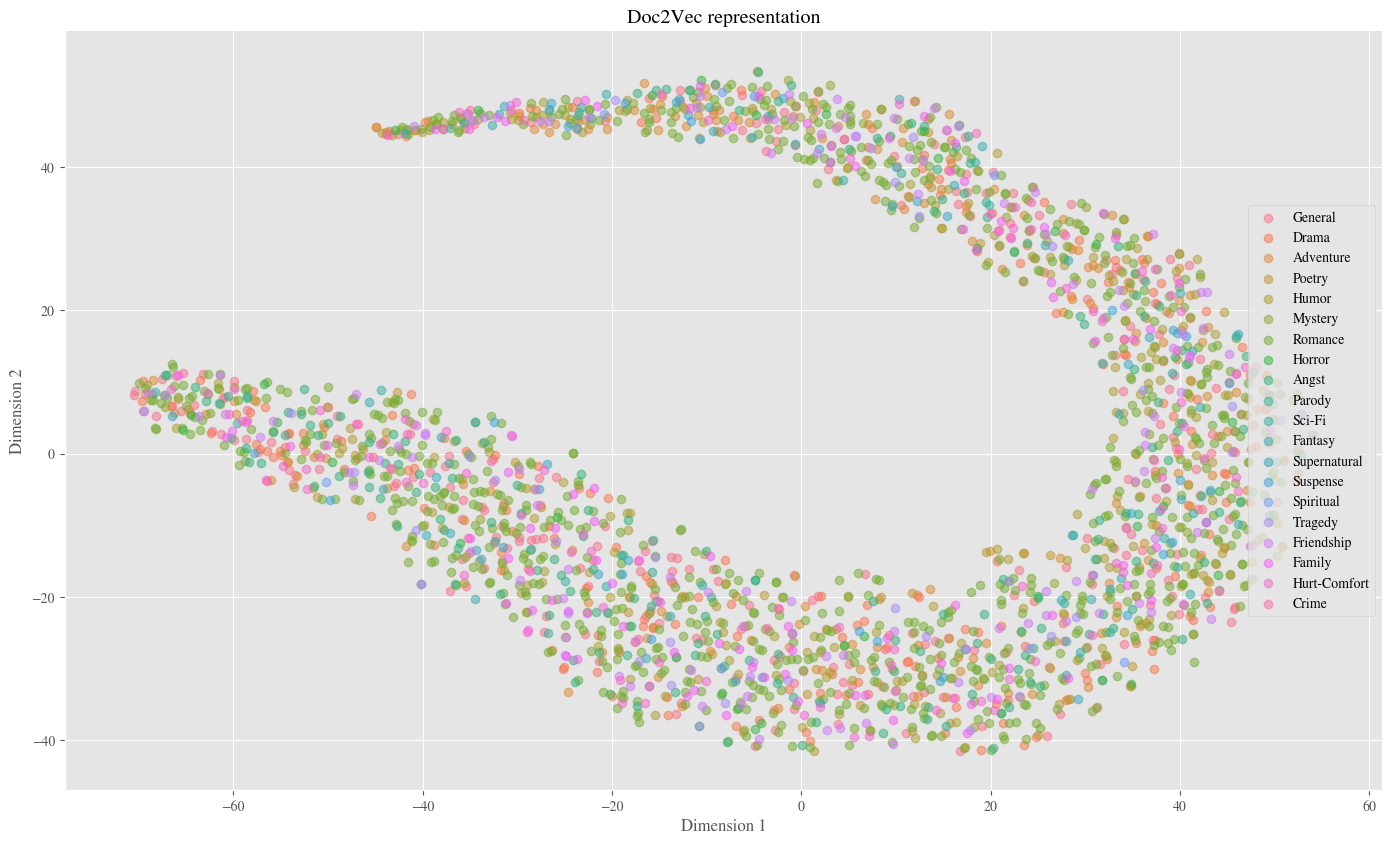

In [226]:
plot_representation(d2v_docm_text, df['main_genre'], 'Doc2Vec representation')

In [227]:
feature_data = df[['storyid', 'main_genre']].copy()
feature_data[['LSA' + str(i) for i in range(n_lsa)]] = pd.DataFrame(lsa_docm_text)
feature_data[['D2V' + str(i) for i in range(n_d2v)]] = pd.DataFrame(d2v_docm_text)

# <a class="anchor" id="six">Sentiment analysis</a>

When we tried to represent our text as numerical topic vectors, we saw that, at least based on a two-dimensional representation of the features, there were no discernable grouping or clustering based on genres. 

Here, we will try to represent the text in a different way. Instead of trying to extract numerical vectors representing its topics or "meaning", we will try to extract only the sentiment of the text. That is, whether the overall tone of the text is positive or negative.

We will try to extract sentiment through three separate methods. The first is the NLTK sentiment intensity analyzer. The second is TextBlob. The third is the Stanford NLP.

## <a class="anchor" id="6a">NLTK Sentiment Intensity Analyzer (VADER)</a> 

The NLTK sentiment intensity analyzer is based on VADER (Valence Aware Dictionary and sEntiment Reasoner), a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

In this approach, each of the words in the lexicon is rated on how positive or negative it is. The sentiments themselves are captured from the ratings of Amazon’s Mechanical Turk.

Unlike other sentiment analyzers, VADER doesn't just match the words in the text and in its lexicon, but also looks at context. It considers both capitalization and punctuation, slangs and acronyms, modifiers and negations/conjunctons.

In [22]:
sia = SentimentIntensityAnalyzer()
sia_scores = []
for s in df.title_summary:
    sia_scores.append(sia.polarity_scores(s))

In [23]:
feature_data['sia_pos'] = [s['pos'] for s in sia_scores]
feature_data['sia_neg'] = [s['neg'] for s in sia_scores]
feature_data['sia_neu'] = [s['neu'] for s in sia_scores]
feature_data['sia_compound'] = [s['compound'] for s in sia_scores]

VADER outputs four scores: positive, negative, neutral, and compound, which represents the aggregate score.

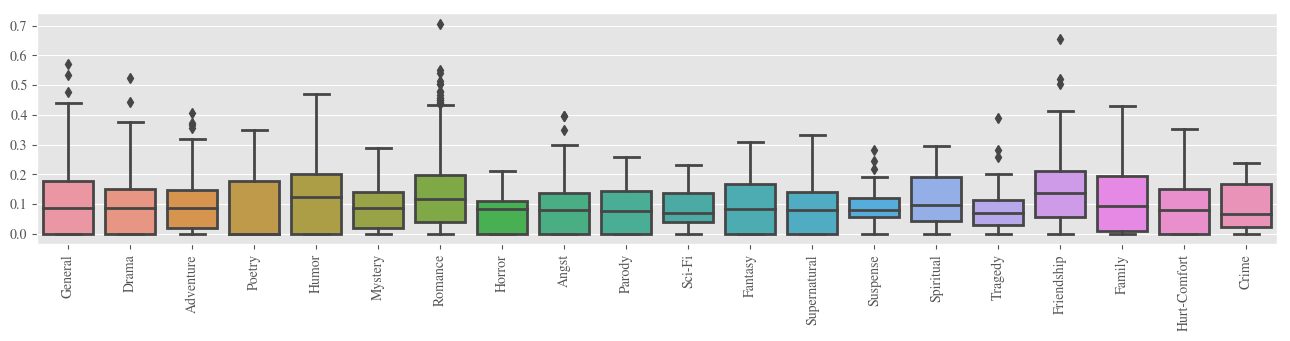

In [34]:
fig, ax = plt.subplots(figsize=(16, 3))
ax = sns.boxplot(x="main_genre", y="sia_pos", data=feature_data)
plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('')
plt.show()

For positivity above, we can see romance and friendship both score highly, which makes a lot of intuitive sense.

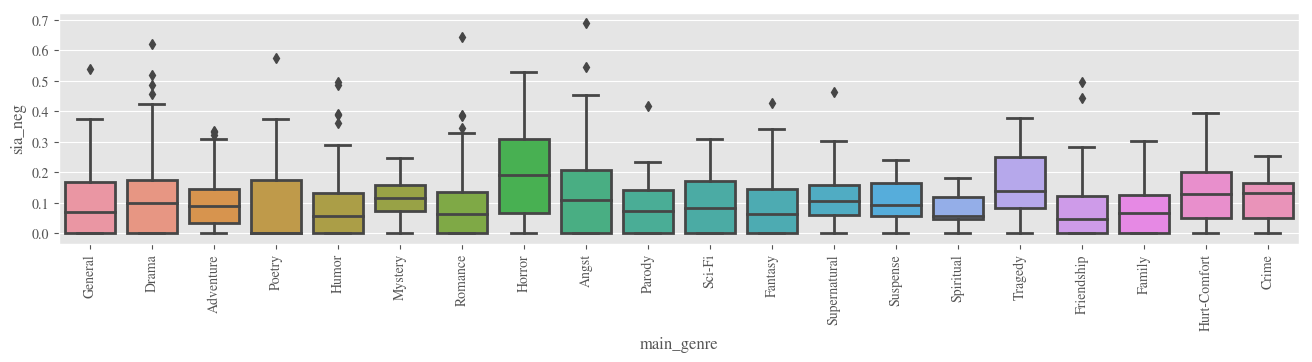

In [29]:
fig, ax = plt.subplots(figsize=(16, 3))
ax = sns.boxplot(x="main_genre", y="sia_neg", data=feature_data)
plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('')
plt.show()

In terms of negativity, horror and tragedy scored highly, which also makes a lot of intuitive sense.

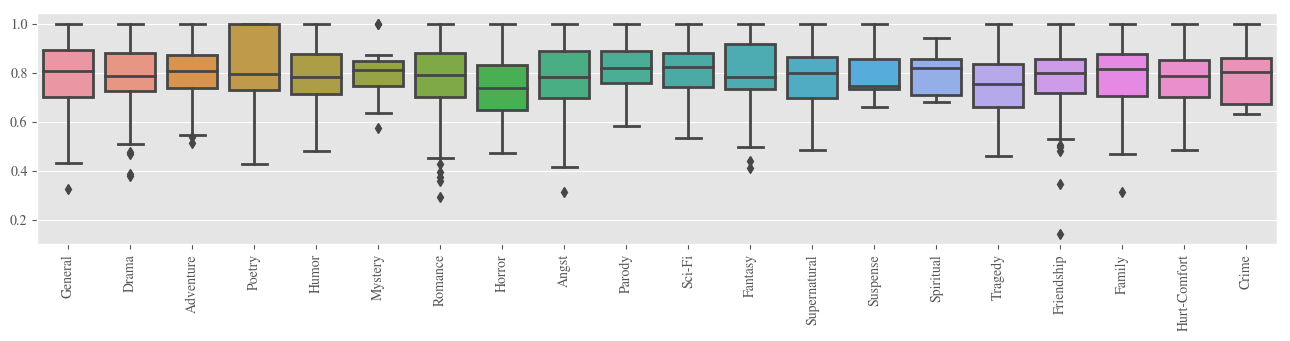

In [35]:
fig, ax = plt.subplots(figsize=(16, 3))
ax = sns.boxplot(x="main_genre", y="sia_neu", data=feature_data)
plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('')
plt.show()

In terms of neutrality, poetry scored the highest.

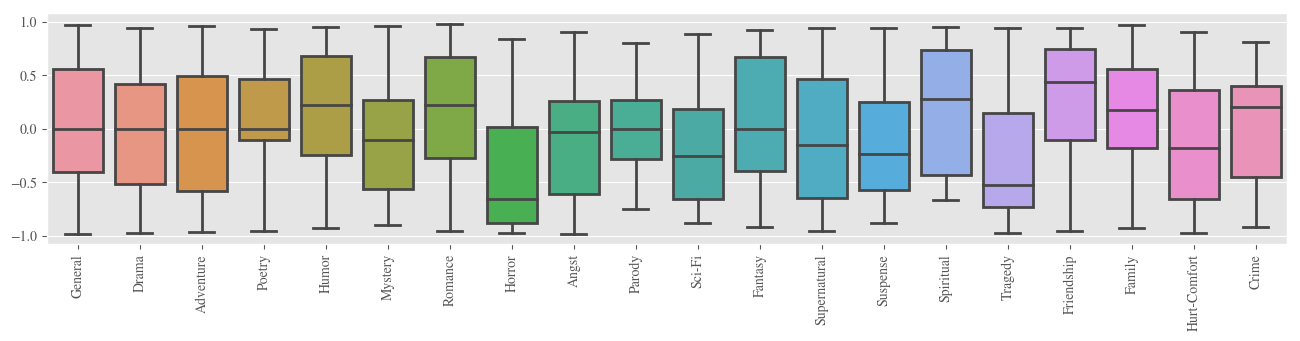

In [36]:
fig, ax = plt.subplots(figsize=(16, 3))
ax = sns.boxplot(x="main_genre", y="sia_compound", data=feature_data)
plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('')
plt.show()

In terms of overall score, humor, romance, spiritual, friendship, family, and crime all scored more positively.

Meanwhile, mystery, horror, sci-fi, supernatural, suspense, tragedy, and hurt-comfort all scored more negatively. 

## <a class="anchor" id="6b">TextBlob Naive Bayes and Pattern Analyzer</a> 

TextBlob is a sentiment altenative that comes in two forms. The first uses the [Pattern Analyzer](https://www.clips.uantwerpen.be/pages/pattern-en), which includes parts of speech tagging and will find the postivity of a piece of text. The second is a simply bag-of-words Naive Bayes classifier, and will find the polarity and subjectivity of a text.

For both, TextBlob is trained on the NLTK movie reviews corpus. 

In [67]:
nba = Blobber(analyzer=NaiveBayesAnalyzer())
pa = Blobber(analyzer=PatternAnalyzer())

def get_blob(s):
    return nba(s).sentiment, pa(s).sentiment

num_cores = multiprocessing.cpu_count()
blob_scores = Parallel(n_jobs=num_cores)(delayed(get_blob)(s) for s in df.title_summary)

In [68]:
feature_data['blob_pos'] = [s[0].p_pos for s in blob_scores]
feature_data['blob_pol'] = [s[1].polarity for s in blob_scores]
feature_data['blob_sub'] = [s[1].subjectivity for s in blob_scores]

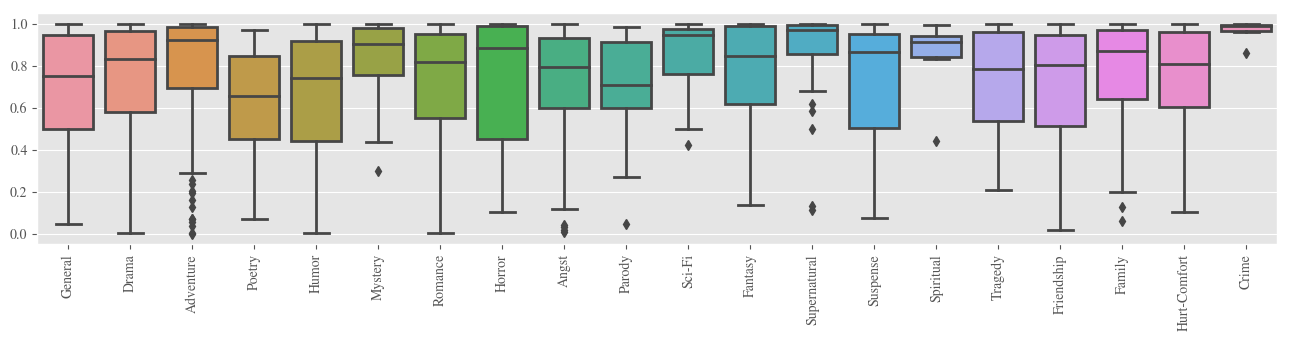

In [72]:
fig, ax = plt.subplots(figsize=(16, 3))
ax = sns.boxplot(x="main_genre", y="blob_pos", data=feature_data)
plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('')
plt.show()

As we can see, TextBlob yields slightly different results. Adventure, mystery, sci-fi, spiritual, and crime are the genres yielding the most positive scores. Meanwhile, poetry and parody yield the most negative.

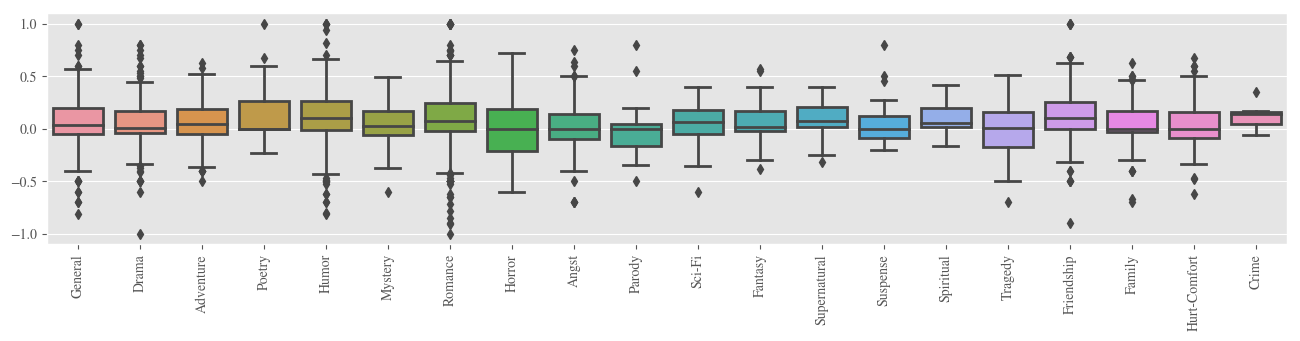

In [75]:
fig, ax = plt.subplots(figsize=(16, 3))
ax = sns.boxplot(x="main_genre", y="blob_pol", data=feature_data)
plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('')
plt.show()

Polarity does not appear to be marked by clear differentiation across genres.

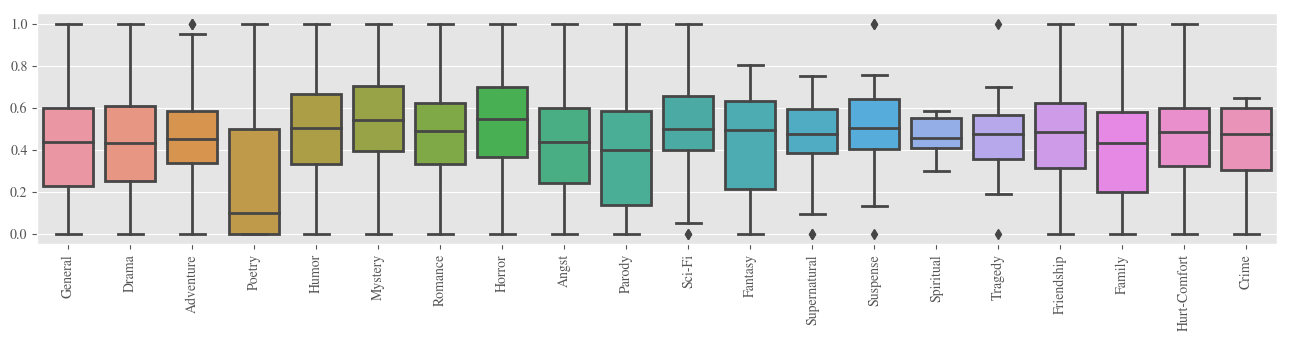

In [76]:
fig, ax = plt.subplots(figsize=(16, 3))
ax = sns.boxplot(x="main_genre", y="blob_sub", data=feature_data)
plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('')
plt.show()

We can see that poetry has the lowest subjectivity score.

## <a class="anchor" id="6c">Stanford NLP Sentiment</a> 

Finally, we will look at the Stanford CoreNLP sentiment analysis. Based on Richard Socher et al's [Recursive Deep Models for Semantic Compositionality Over a Sentiment Treebank](https://nlp.stanford.edu/sentiment/), the model uses a recursive neural network that uses tensors instead of matrices as parameters.

The model is trained on a sentiment treebank, which is left open-source of manual validation. The treebank associates the individual phrases of various sizes with sentiment labels. Instead of predicting sentiment from whole sentences, the model uses an incremental approach in which the neural network associates subparts of sentences then combines them. 

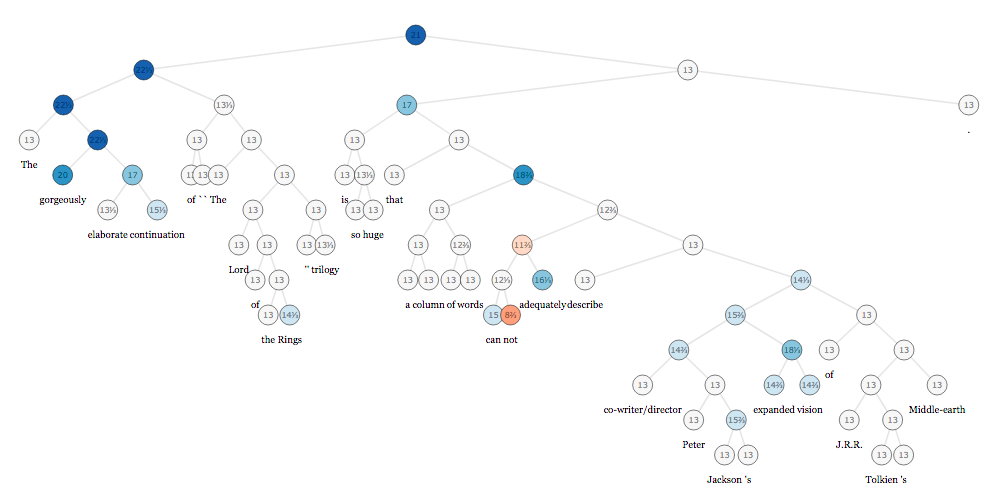

To use the Stanford NLP, we had to first install and run the server.

In [23]:
# java -mx1g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 25000

stanford_scores = []
for s in df.title_summary:
    s = re.sub('[\[\]]+', '', s)
    result = stanford.annotate(s,
                               properties={
                                'annotators': 'sentiment',
                                'outputFormat': 'json',
                                'timeout': '10000'
                               })
    for r in result['sentences']:
        score = (r['sentimentValue'], r['sentimentDistribution'])
    stanford_scores.append(score)

In [24]:
feature_data['stanford_score'] = [int(g[0]) for g in stanford_scores]
feature_data['stanford_s1'] = [g[1][0] for g in stanford_scores]
feature_data['stanford_s2'] = [g[1][1] for g in stanford_scores]
feature_data['stanford_s3'] = [g[1][2] for g in stanford_scores]
feature_data['stanford_s4'] = [g[1][3] for g in stanford_scores]
feature_data['stanford_s5'] = [g[1][4] for g in stanford_scores]

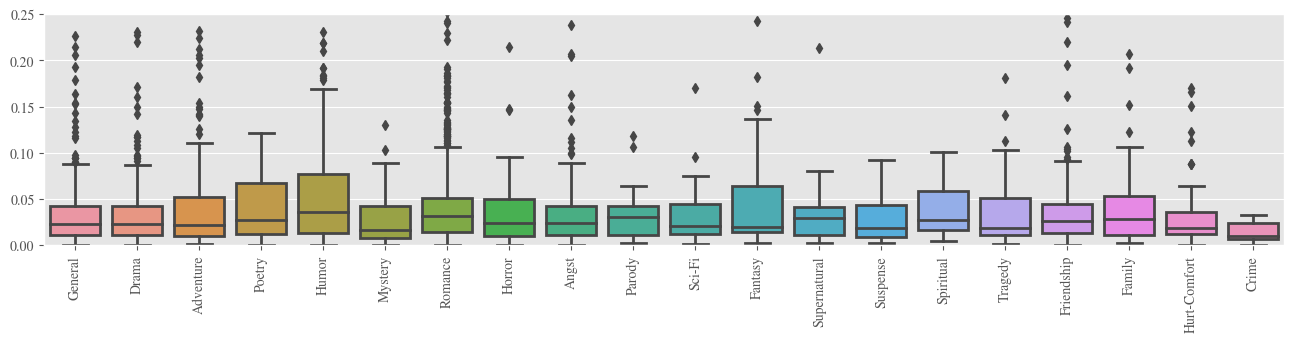

In [6]:
fig, ax = plt.subplots(figsize=(16, 3))
ax = sns.boxplot(x="main_genre", y="stanford_s5", data=feature_data)
plt.xticks(rotation=90)
plt.ylim(0, 0.25)
plt.ylabel('')
plt.xlabel('')
plt.show()

For the positive end of the sentiment distribution, we can see humor scores the highest.

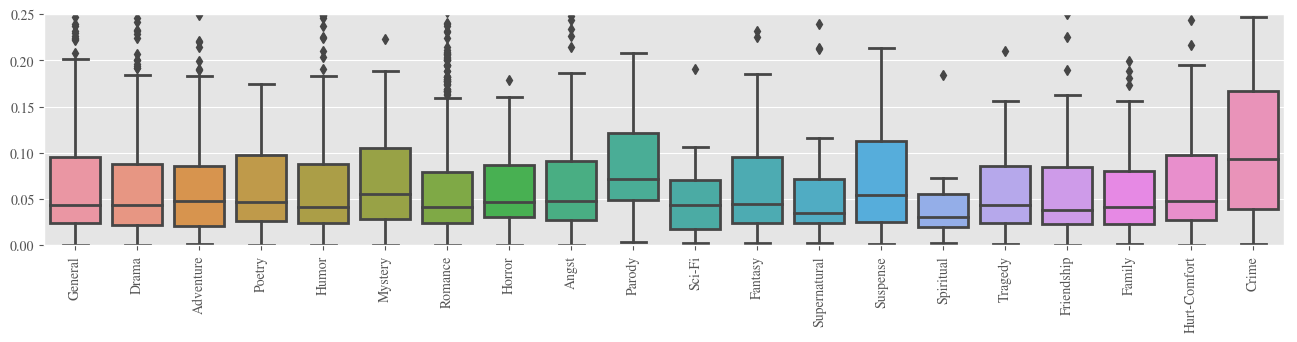

In [7]:
fig, ax = plt.subplots(figsize=(16, 3))
ax = sns.boxplot(x="main_genre", y="stanford_s1", data=feature_data)
plt.xticks(rotation=90)
plt.ylim(0, 0.25)
plt.ylabel('')
plt.xlabel('')
plt.show()

Meanwhile, crime is the highest for the negative end of the distribution.

# <a class="anchor" id="six">Emotion analysis</a>

Emotion analysis is an extension of sentiment analysis that replaces the positive-negative spectrum with the full range of emotions, such as joy, sadness, or anger.

Unlike sentiment analysis, we were unable to find any built-in libraries for emotion analysis. As such, we will be constructing our own emotion metrics. To do this, we will be using NRC emotion lexicons. These are the EmoLex, the Affect Intensity Lexicon, the VAD lexicon, and the Twitter Hashtag lexicon.

## <a class="anchor" id="7a">NRC Word-Emotion Association Lexicon (EmoLex)</a> 

The EmoLex, or NRC Word-Emotion Association Lexicon has annotations for eight emotions across 14,182 unigrams. It uses a binary category in which 1 means a word is associated with an emotion and 0 otherwise. This lexicon is manually collected through crowdsourcing.

Below, we have printed 10 random rows:

In [190]:
random_indices = list(np.random.choice(emolex.loc[emolex.is_emotion==1].index, 10))
emolex.iloc[random_indices]

,term,emotion,is_emotion
30299,cuddle,trust,1
75198,loyal,surprise,1
183,abhorrent,fear,1
110090,savagery,anger,1
113116,shapely,positive,1
82235,murky,negative,1
36517,disconnect,sadness,1
39855,drudgery,negative,1
71406,land,positive,1
116233,smite,fear,1


In [10]:
print(base_emotions)

['fear', 'negative', 'positive', 'sadness', 'trust', 'anger', 'joy', 'anticipation', 'surprise', 'disgust']


The different emotions are shown above.

Now, for each text, we will construct a simple count for each emotion.

In [ ]:
token_text = [simple_tokenize(t) for t in df.title_summary]

In [9]:
for emo in base_emotions:
    emo_terms = set(emolex.loc[(emolex.emotion == emo) & (emolex.is_emotion == 1)].term)
    emo_results = []
    for summary in token_text:
        emo_results.append(np.sum([w in emo_terms for w in summary]))
    feature_data['nrc_' + emo] = emo_results

Below, we will show the normalized aggregated counts for each genre:

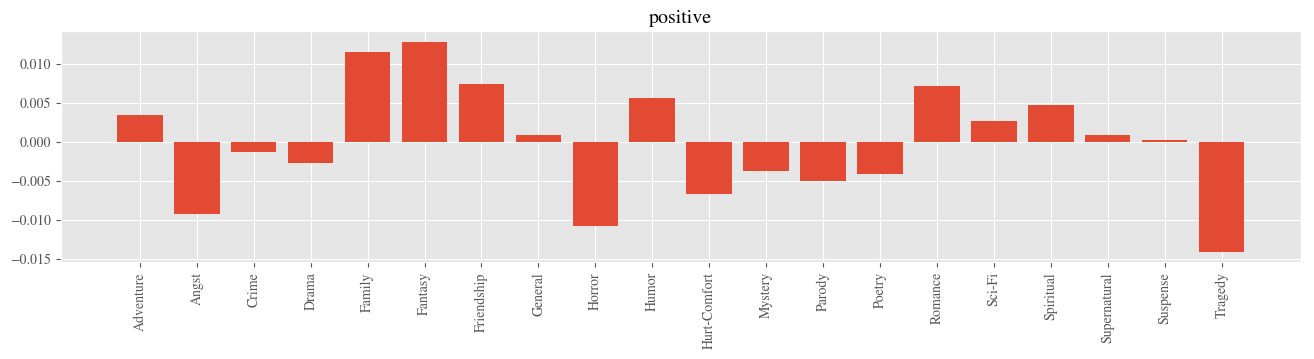

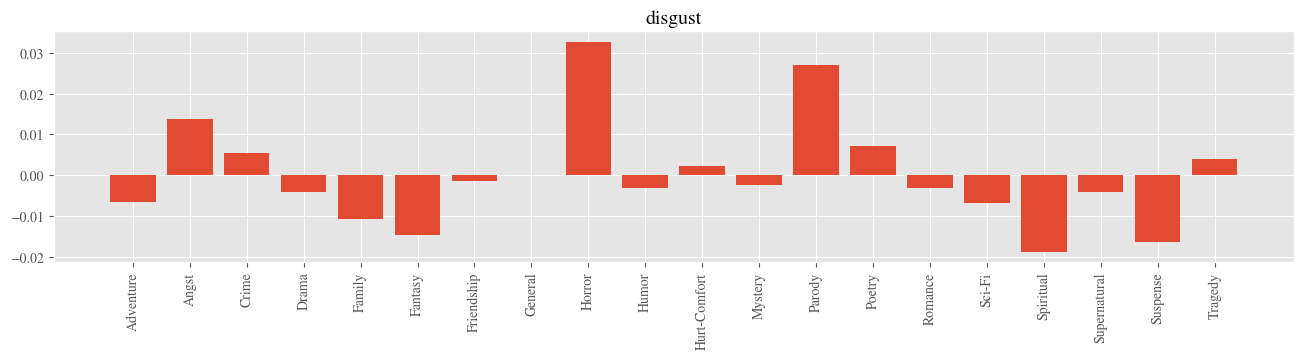

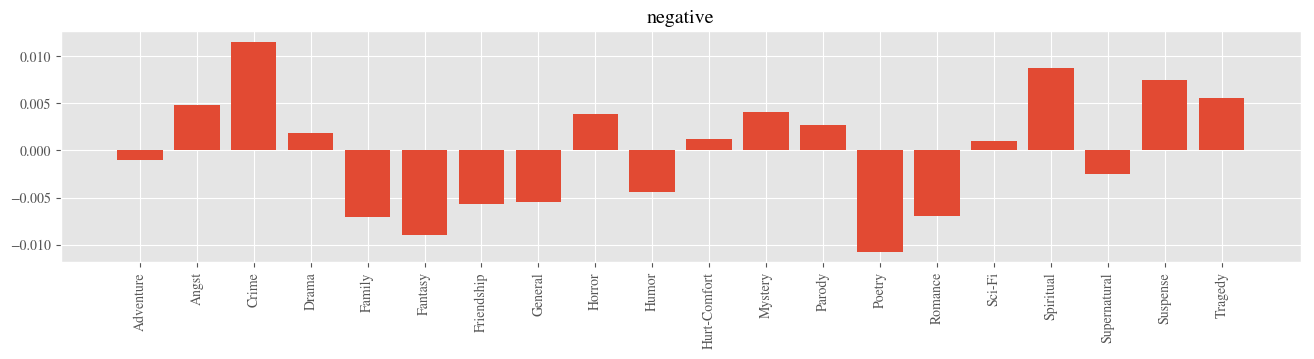

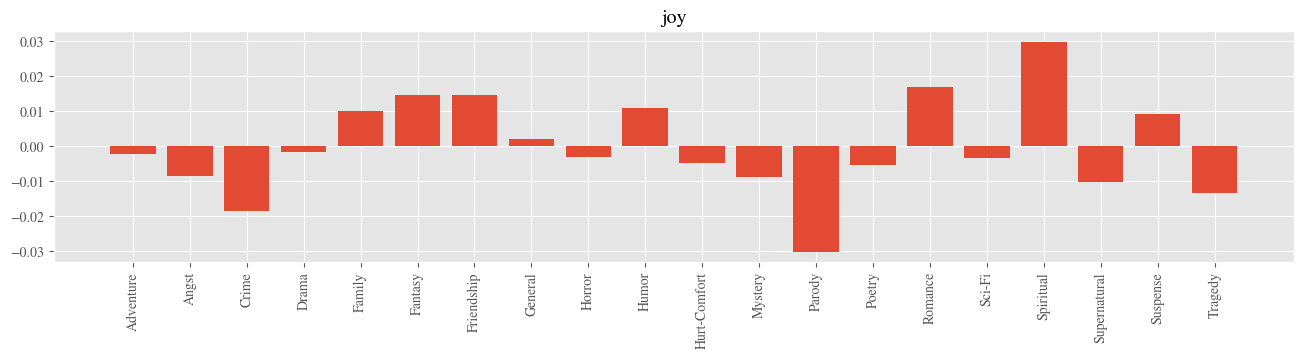

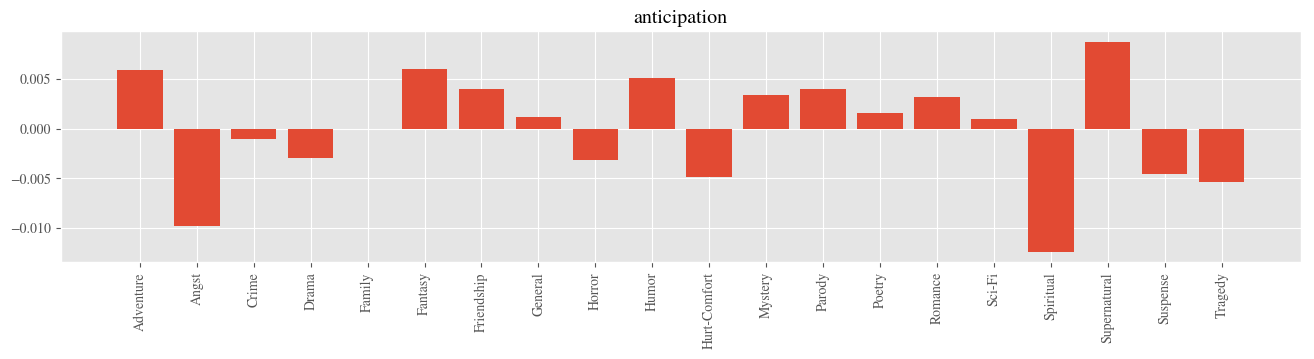

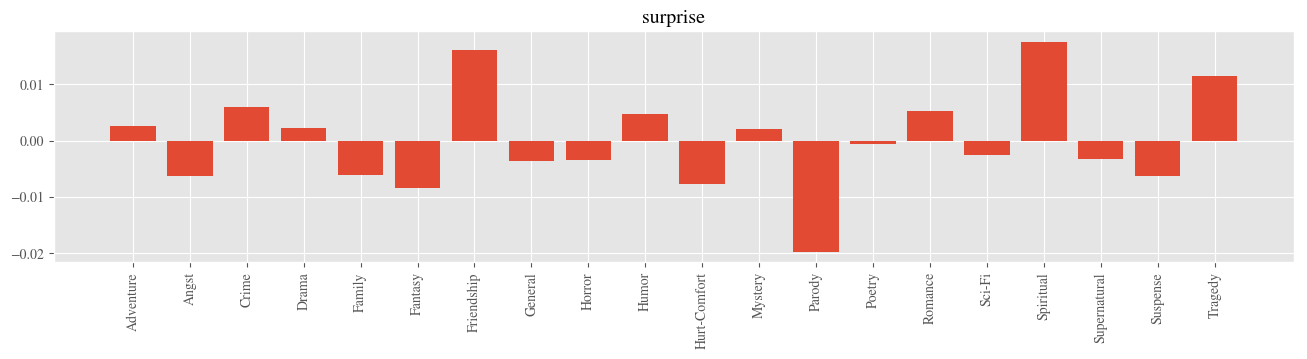

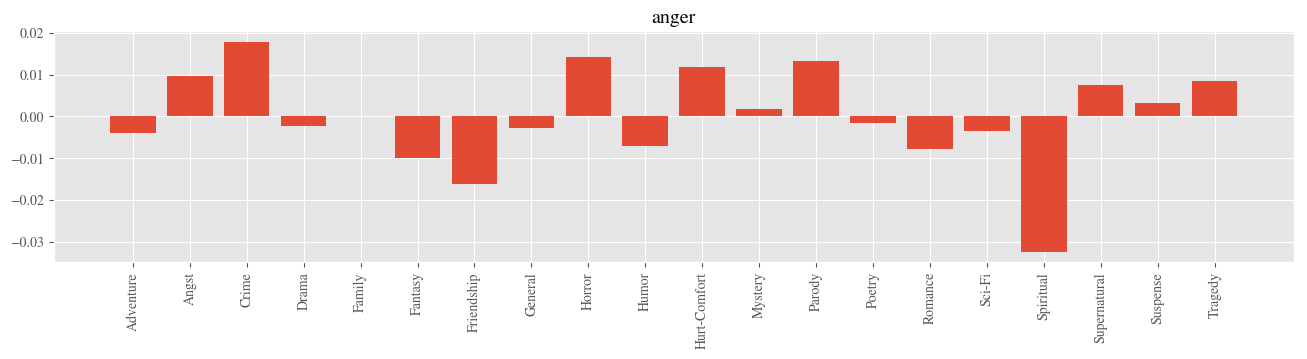

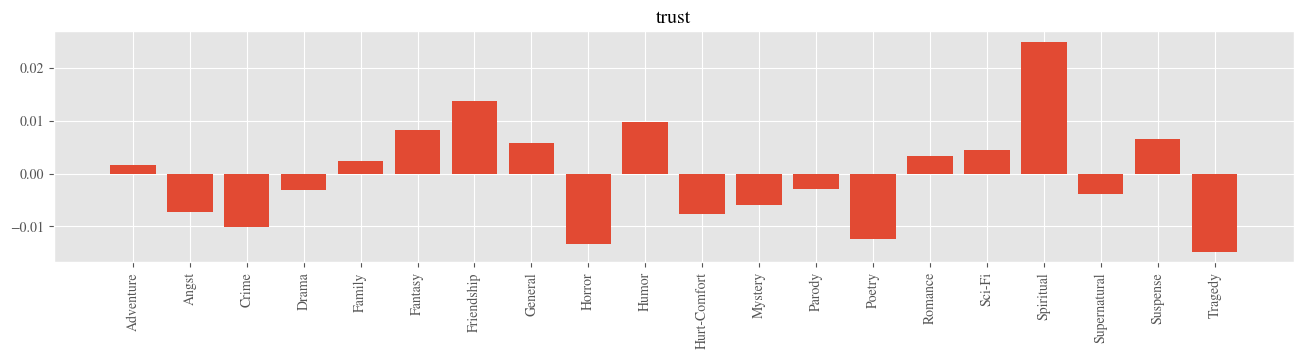

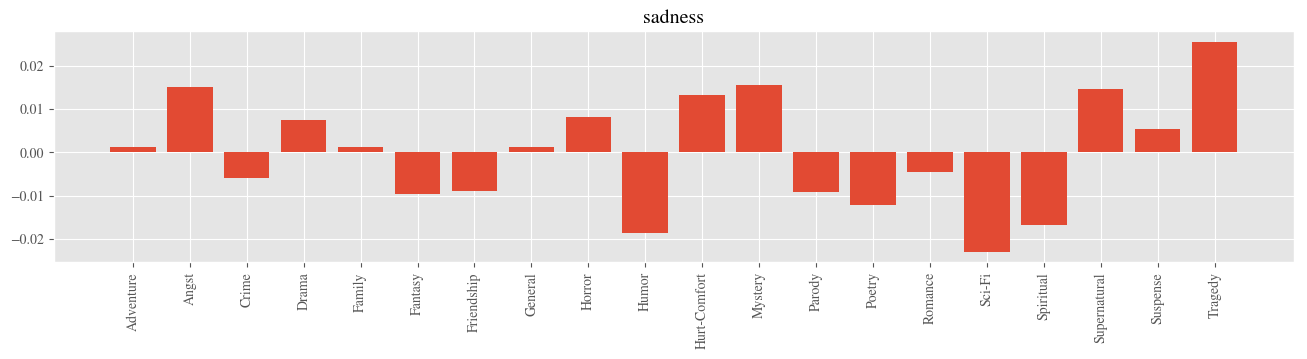

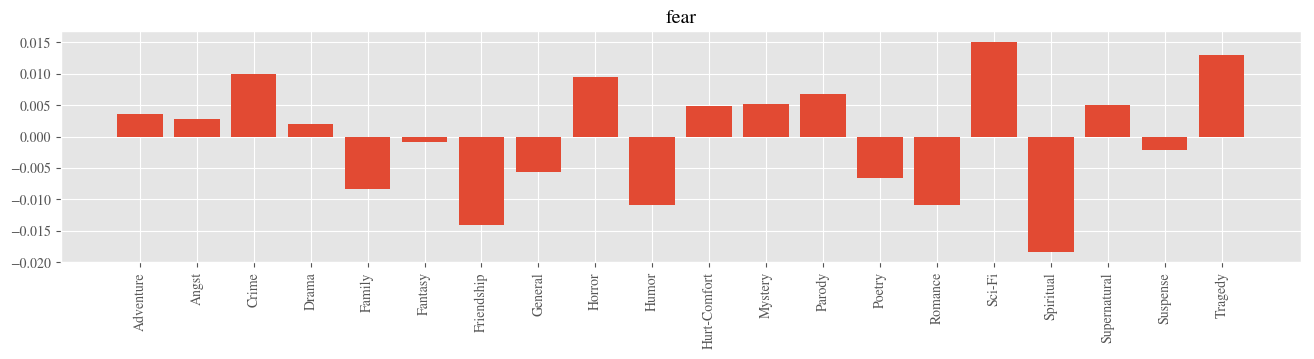

In [85]:
plot_emotions('nrc_', base_emotions)

The results align extremely close with our intuition! For example, horror scores highly in both disgust and fear, whereas tragedy scores highest in sadness.

## <a class="anchor" id="7b">NRC Emotion Intensity Lexicon (Affect Intensity Lexicon)</a>

The Affect Intensity Lexicon is a list of English words and their associations with four basic emotions (anger, fear, sadness, joy). Unlike the previous lexicon, here words are associated with different intensities of an emotion. Like the previous lexicon, it was manually constructed, with scaling applied.

- A score of 1 means that the word has the highest amount of emotion.
- A score of 0 means that the word has the lowest amount of emotion.

The lexicon contains approximately 6,000 words.

In [193]:
random_indices = list(np.random.choice(range(intlex.shape[0]), 5))
intlex.iloc[random_indices]

,term,score,emotion
3850,sullen,0.531,sadness
1798,terminal,0.703,fear
4074,bothering,0.435,sadness
2541,aghhh,0.438,fear
2441,austere,0.470,fear


In [8]:
print(intensity_emotions)

['joy', 'sadness', 'fear', 'anger']


In [10]:
for emo in intensity_emotions:
    emo_terms = intlex.loc[intlex.emotion == emo].term.values
    emo_values = intlex.loc[intlex.emotion == emo].score.values
    emo_results = []
    for summary in token_text:
        emo_results.append(np.sum(emo_values[np.isin(emo_terms, summary)]))
    feature_data['nrc_int_' + emo] = emo_results

As with before, we will examine the emotions across genres.

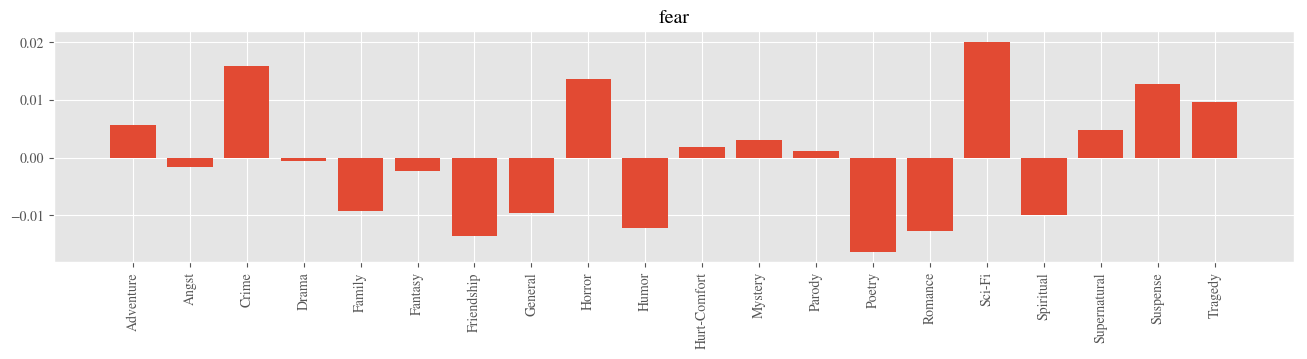

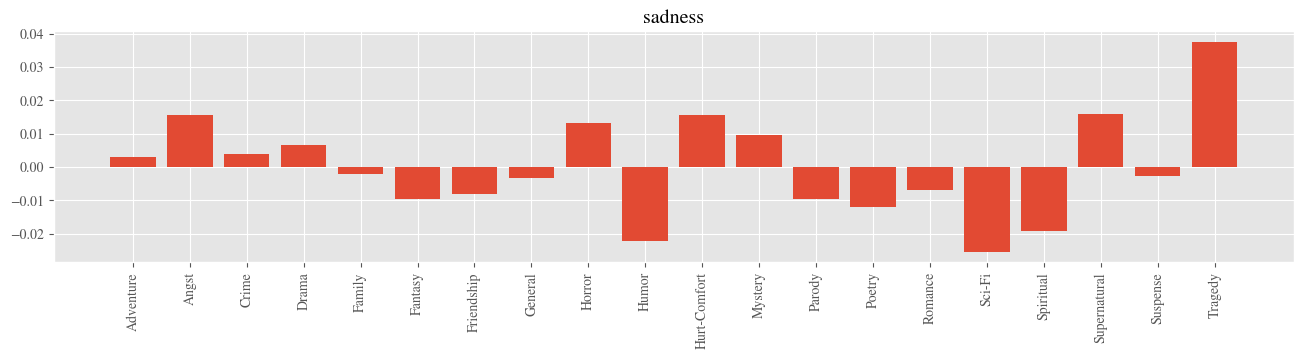

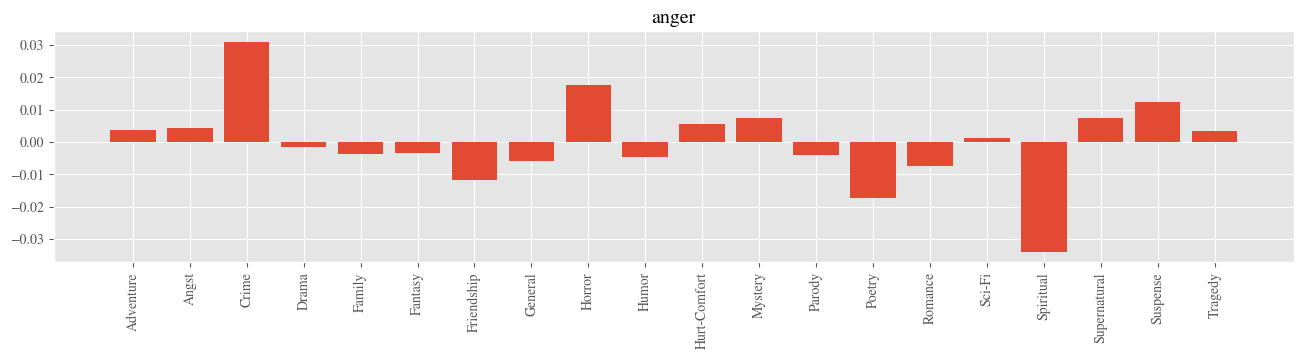

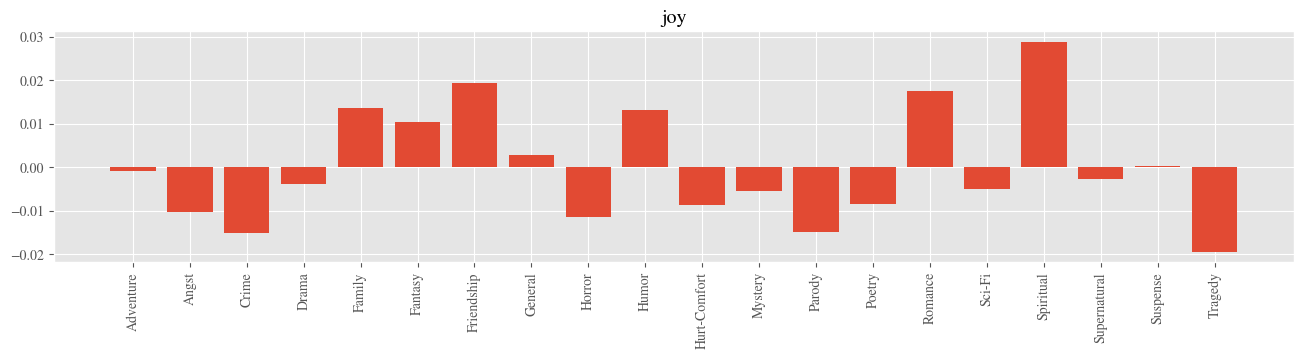

In [124]:
plot_emotions('nrc_int_', intensity_emotions)

Sci-fi has the most fear, tragedy has the most sadness, crime has the most anger, and spiritual has the most joy.

## <a class="anchor" id="7c">NRC Valence, Arousal, Dominance Lexicon</a> 

The VAD lexicon is based on influential factor analysis studies, which have shown that the primary dimensions of word meaning are valence, arousal, and dominance.

- Valence is the positive--negative dimension
- Arousal is the active--passive dimension
- Dominance is the powerful--weak dimension

This lexicon has more than 20,000 words and their valence, arousal, and dominance scores, which range from 0 to 1, and created by manual annotation with scaling.

In [82]:
random_indices = list(np.random.choice(range(vadlex.shape[0]), 5))
vadlex.iloc[random_indices]

,term,valence,arousal,dominance
20004,zoology,0.568,0.347,0.509
9462,interstate,0.520,0.443,0.600
10697,manhood,0.625,0.735,0.858
9397,intensify,0.604,0.870,0.737
14553,register,0.490,0.412,0.654


In [12]:
print(vad_emotions)

['valence', 'arousal', 'dominance']


In [12]:
val_results = []
aro_results = []
dom_results = []    
for summary in token_text:
    has_terms = np.isin(vadlex.term.values, summary)
    val_results.append(np.sum(vadlex['valence'][has_terms]))
    aro_results.append(np.sum(vadlex['arousal'][has_terms]))
    dom_results.append(np.sum(vadlex['dominance'][has_terms]))
feature_data['nrc_vad_valence'] = val_results
feature_data['nrc_vad_arousal'] = aro_results
feature_data['nrc_vad_dominance'] = dom_results

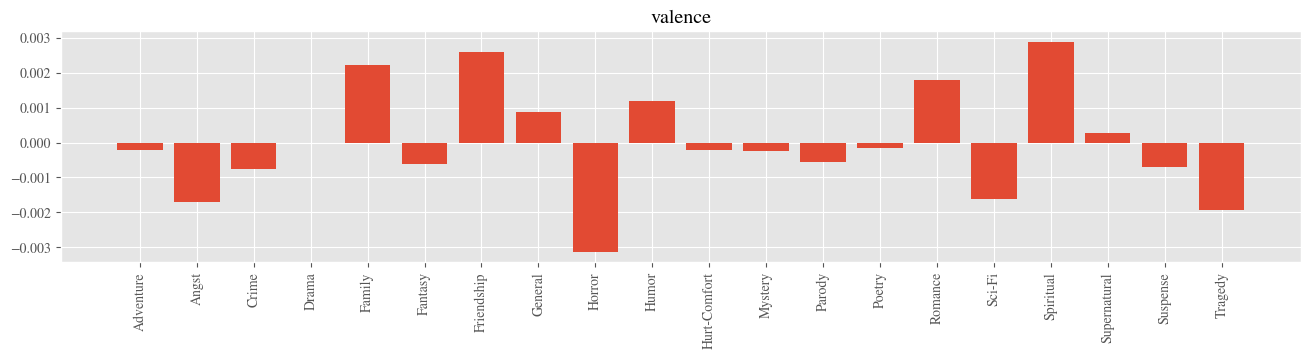

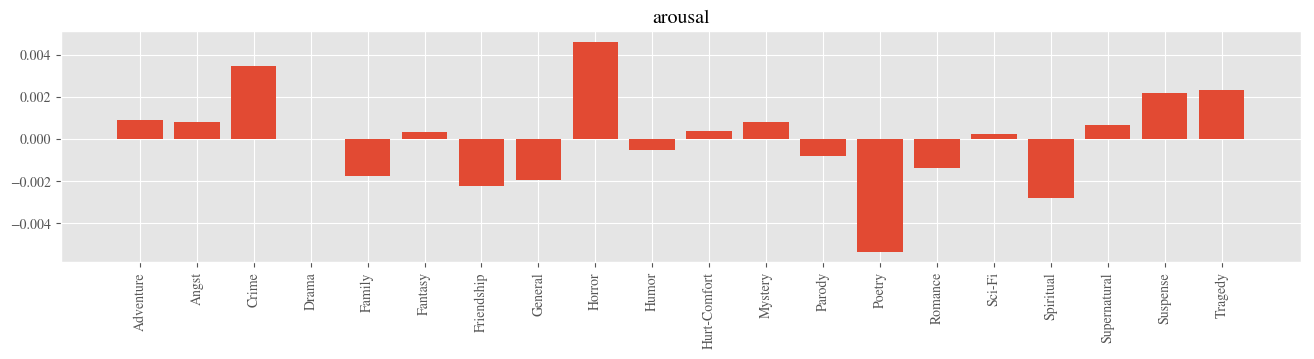

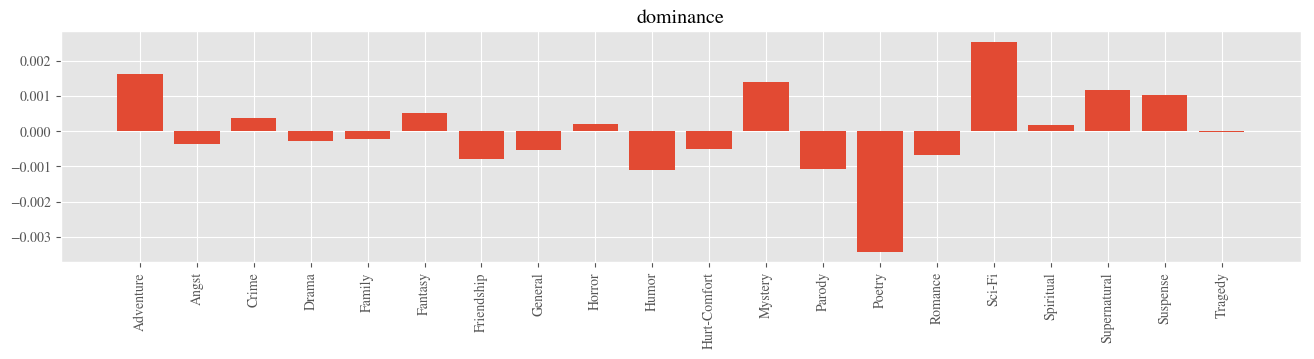

In [122]:
plot_emotions('nrc_vad_', vad_emotions)

Spiritual has the highes valence, horror has the highest arousal, and sci-fi has the highest dominance.

## <a class="anchor" id="7d">NRC Hashtag Emotion Lexicon</a> 

The Twitter Emotion Corpus, also known as the Hashtag Emotion Corpus, is an automated lexicon that is generated from tweets. The score is determined by the word's tendency to co-occur with the emotion-word hashtag. 

The advantage of this lexicon is that is is much larger than manually created lexicons and cover slang and internet phrases.

In [83]:
random_indices = list(np.random.choice(range(hashlex.shape[0]), 5))
hashlex.iloc[random_indices]

,emotion,hashtag,score
21034,sadness,dreary,2.220582
19485,surprise,bounce,0.185969
30931,disgust,believe,0.255546
24157,joy,flows,1.421069
26321,joy,production,0.222374


In [13]:
print(hash_emotions)

['disgust', 'fear', 'sadness', 'anger', 'joy', 'anticipation', 'surprise', 'trust']


In [11]:
for emo in hash_emotions:
    emo_terms = hashlex.loc[hashlex.emotion == emo].hashtag.values
    emo_values = hashlex.loc[hashlex.emotion == emo].score.values
    emo_results = []
    for summary in token_text:
        emo_results.append(np.sum(emo_values[np.isin(emo_terms, summary)]))
    feature_data['nrc_hash_' + emo] = emo_results

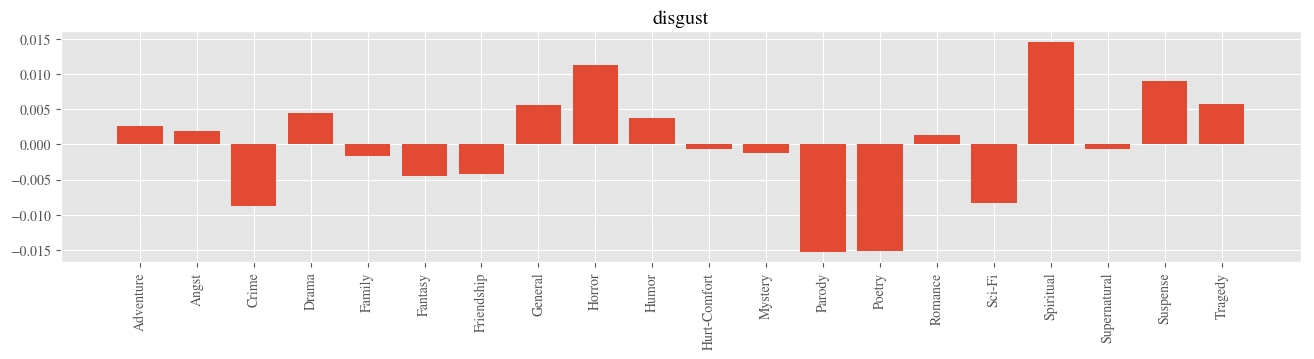

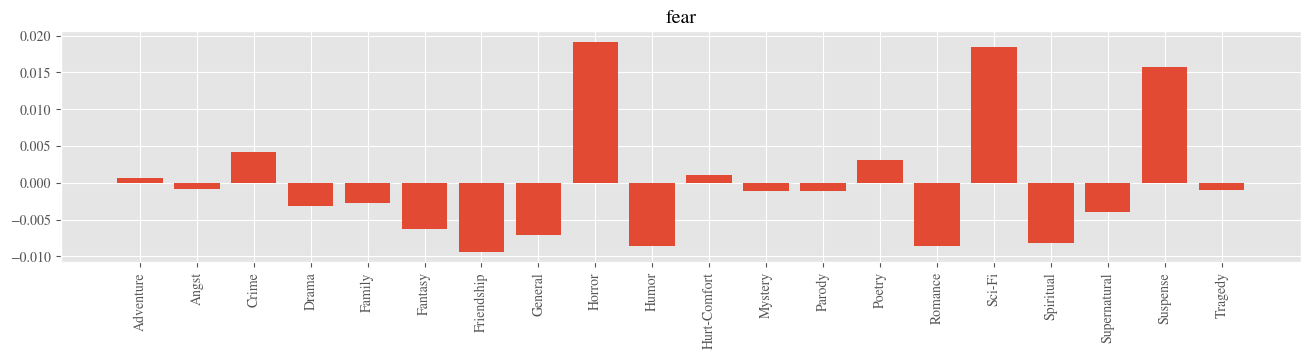

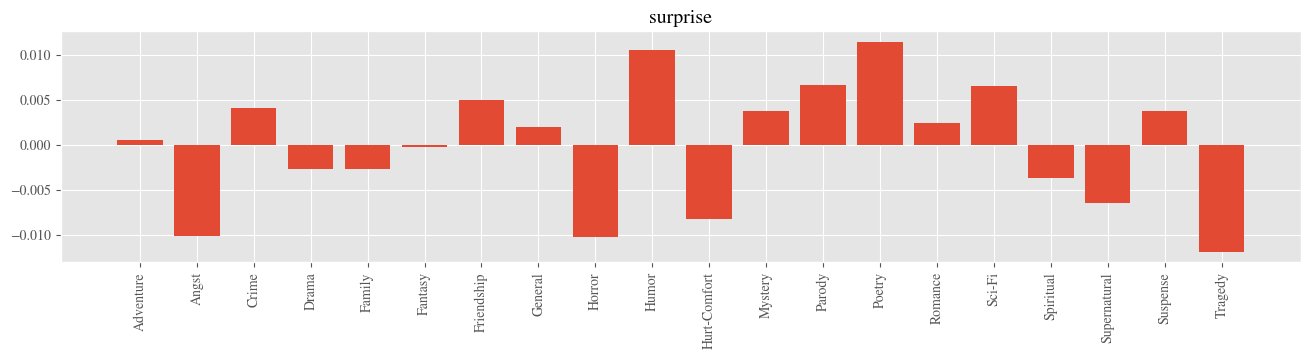

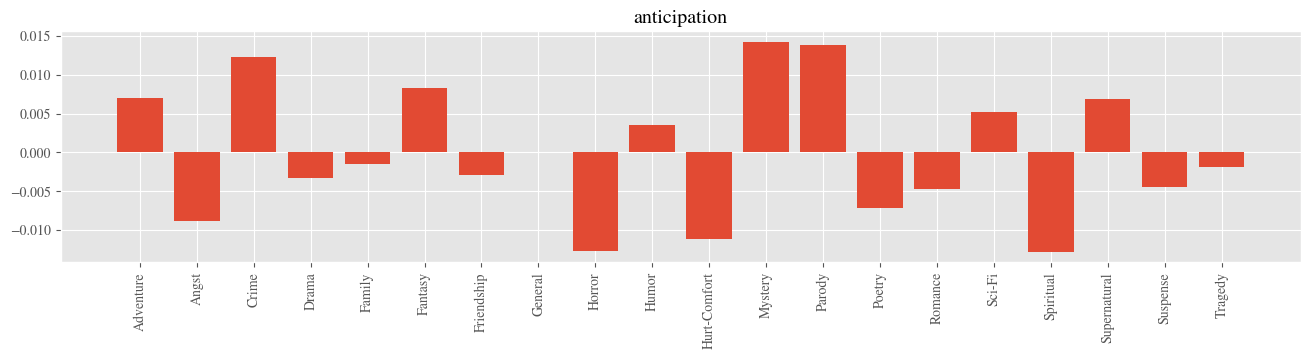

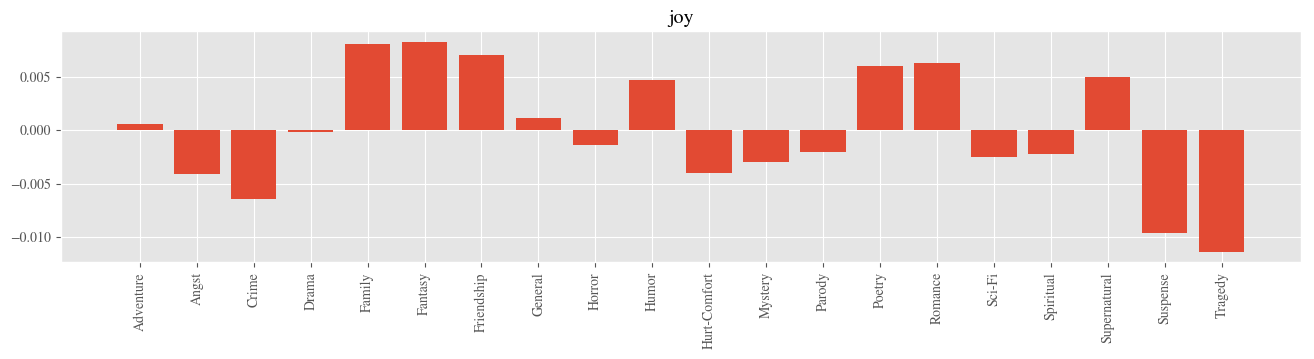

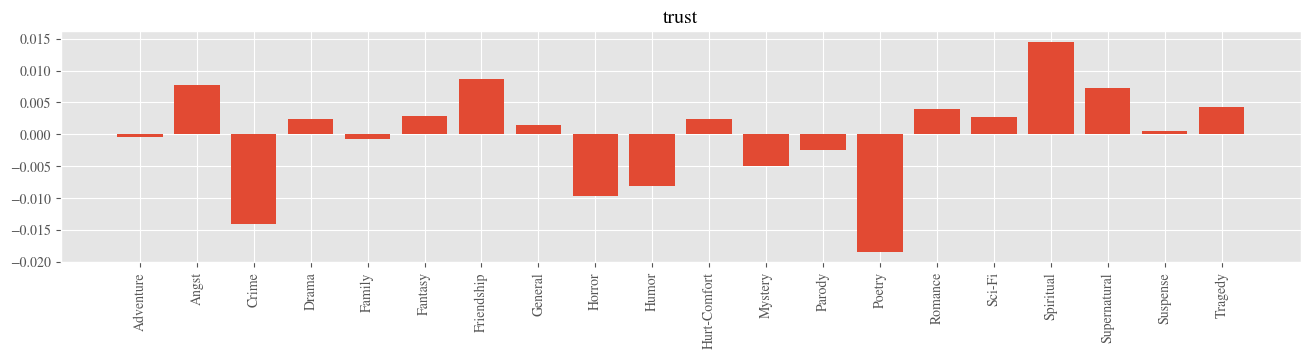

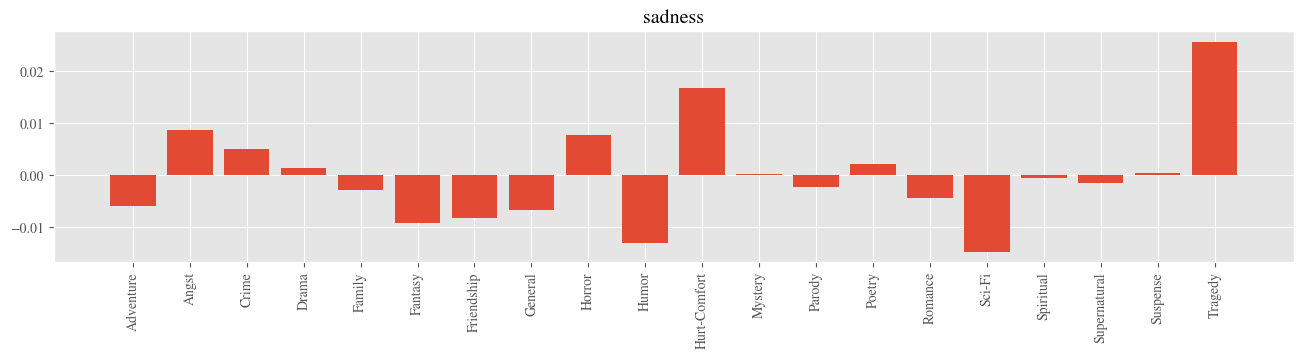

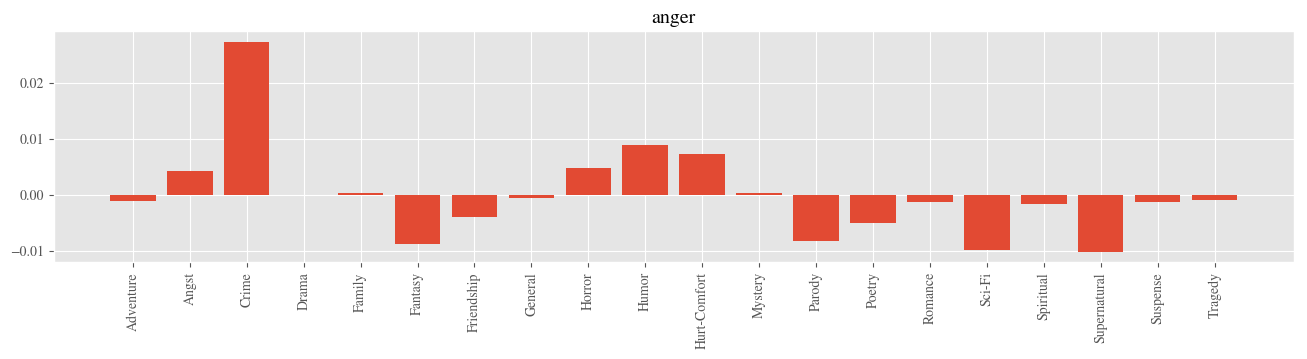

In [125]:
plot_emotions('nrc_hash_', hash_emotions)

While there is a lot of overlap in the results with the manual database, it would appear there are dissimilarities too. For example, spiritual here rated very highly in disgust, whereas the reverse is true in the EmoLex results.

# <a class="anchor" id="eight">Classification</a> 

In our final section, we will try to predict genre based off the sentiments and emotions extracted from our text.

In [261]:
# sentiment variables
sia_vars = ['sia_pos', 'sia_neg', 'sia_neu', 'sia_compound']
blob_vars = ['blob_pos', 'blob_pol', 'blob_sub']
stanford_vars = ['stanford_s1', 'stanford_s2', 'stanford_s4', 'stanford_s5']

# emotion variables
base_emotion_vars = ['nrc_' + e for e in base_emotions]
intensity_emotion_vars = ['nrc_int_' + e for e in intensity_emotions]
hash_emotion_vars = ['nrc_hash_' + e for e in hash_emotions]
vad_emotion_vars = ['nrc_vad_' + e for e in vad_emotions]

sentiment_vars = sia_vars + blob_vars + stanford_vars
emotion_vars = base_emotion_vars + intensity_emotion_vars + hash_emotion_vars + vad_emotion_vars

In [433]:
classification_data = pd.DataFrame()
classification_data = feature_data[sentiment_vars + emotion_vars].copy()

#classification_data['storyid'] = df['storyid'].astype('int')
#classification_data['words'] = df['words'].astype('int')
#classification_data[['LSA' + str(i) for i in range(50)]] = feature_data[['LSA' + str(i) for i in range(50)]]
#classification_data[['D2V' + str(i) for i in range(20)]] = feature_data[['D2V' + str(i) for i in range(20)]]

## Multiclass logistic regression

In [407]:
X = scale(classification_data.values)
Y = feature_data['main_genre'].factorize()[0]
n_classes = len(set(Y))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=0)
y_train_bin = label_binarize(y_train, classes=list(set(Y)))
y_test_bin = label_binarize(y_test, classes=list(set(Y)))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1641, 50) (884, 50) (1641,) (884,)


In [408]:
clf = LogisticRegression(random_state=0, solver='newton-cg', max_iter=500,
                         multi_class='multinomial').fit(X_train, y_train)
y_pred = clf.predict_proba(X_test) 

In [409]:
best_preds = np.asarray([np.argmax(line) for line in y_pred])
print('Accuracy: ', accuracy_score(y_test, best_preds))

Accuracy:  0.28846153846153844


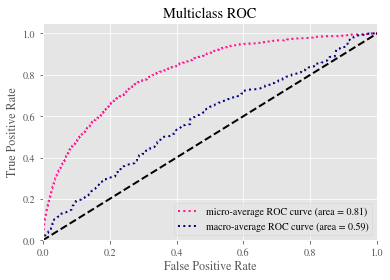

In [410]:
plot_ROC(y_test_bin, y_pred)

## Support vector machine

In [411]:
X = scale(classification_data.values)
Y = feature_data['main_genre'].factorize()[0]
n_classes = len(set(Y))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=0)
y_train_bin = label_binarize(y_train, classes=list(set(Y)))
y_test_bin = label_binarize(y_test, classes=list(set(Y)))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1641, 50) (884, 50) (1641,) (884,)


In [412]:
classifier = OneVsRestClassifier(svm.SVC(kernel='rbf', probability=True, gamma='scale', random_state=0))
y_pred = classifier.fit(X_train, y_train_bin).decision_function(X_test)

In [413]:
best_preds = np.asarray([np.argmax(line) for line in y_pred])
print(accuracy_score(y_test, best_preds))

0.29298642533936653


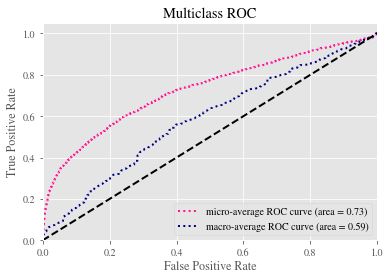

In [414]:
plot_ROC(y_test_bin, y_pred)

## KNN

In [415]:
X = scale(classification_data.values)
Y = feature_data['main_genre'].factorize()[0]
n_classes = len(set(Y))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=0)
y_train_bin = label_binarize(y_train, classes=list(set(Y)))
y_test_bin = label_binarize(y_test, classes=list(set(Y)))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1641, 50) (884, 50) (1641,) (884,)


In [416]:
knn = KNeighborsClassifier(n_neighbors=n_classes).fit(X_train, y_train) 
y_pred = knn.predict_proba(X_test)

In [417]:
best_preds = np.asarray([np.argmax(line) for line in y_pred])
print('Accuracy: ', accuracy_score(y_test, best_preds))

Accuracy:  0.29524886877828055


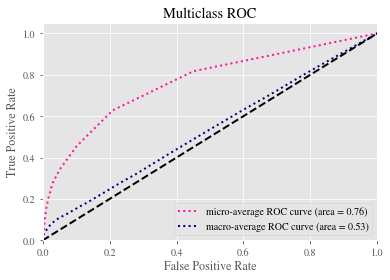

In [418]:
plot_ROC(y_test_bin, y_pred)

## Gaussian naive bayes

In [419]:
X = scale(classification_data.values)
Y = feature_data['main_genre'].factorize()[0]
n_classes = len(set(Y))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=0)
y_train_bin = label_binarize(y_train, classes=list(set(Y)))
y_test_bin = label_binarize(y_test, classes=list(set(Y)))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1641, 50) (884, 50) (1641,) (884,)


In [420]:
clf = GaussianNB().fit(X_train, y_train)
y_pred = clf.predict_proba(X_test) 

In [421]:
best_preds = np.asarray([np.argmax(line) for line in y_pred])
print('Accuracy: ', accuracy_score(y_test, best_preds))

Accuracy:  0.16063348416289594


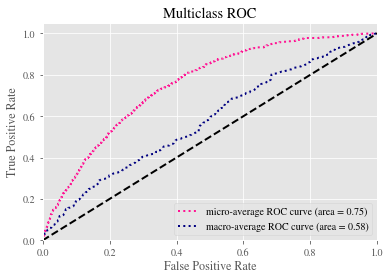

In [422]:
plot_ROC(y_test_bin, y_pred)

## Multi-layer perceptron classifier

In [423]:
X = scale(classification_data.values)
Y = feature_data['main_genre'].factorize()[0]
n_classes = len(set(Y))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=0)
y_train_bin = label_binarize(y_train, classes=list(set(Y)))
y_test_bin = label_binarize(y_test, classes=list(set(Y)))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1641, 50) (884, 50) (1641,) (884,)


In [424]:
clf = MLPClassifier(max_iter=2000).fit(X_train, y_train)
y_pred = clf.predict_proba(X_test) 

In [425]:
best_preds = np.asarray([np.argmax(line) for line in y_pred])
print('Accuracy: ', accuracy_score(y_test, best_preds))

Accuracy:  0.21153846153846154


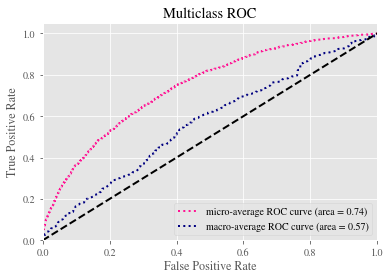

In [426]:
plot_ROC(y_test_bin, y_pred)

## XGBoost multiclass

In [434]:
X = classification_data
Y = feature_data['main_genre'].factorize()[0]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=0)
y_train_bin = label_binarize(y_train, classes=list(set(Y)))
y_test_bin = label_binarize(y_test, classes=list(set(Y)))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1641, 36) (884, 36) (1641,) (884,)


In [435]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [436]:
param = {
    'booster': 'gbtree',
    'n_jobs': 8,
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.05,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'reg_alpha': 10,
    'reg_lambda': 10,
    'gamma': 0,
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': len(np.unique(y_train)), # the number of classes that exist in this datset
    'early_stopping_rounds': 20}  

num_round = 200  # the number of training iterations

bst = xgb.train(param, dtrain, num_round)
y_pred = bst.predict(dtest)

In [437]:
best_preds = np.asarray([np.argmax(line) for line in y_pred])
print(accuracy_score(y_test, best_preds))

0.3235294117647059


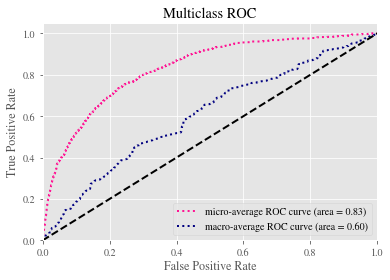

In [438]:
plot_ROC(y_test_bin, y_pred)

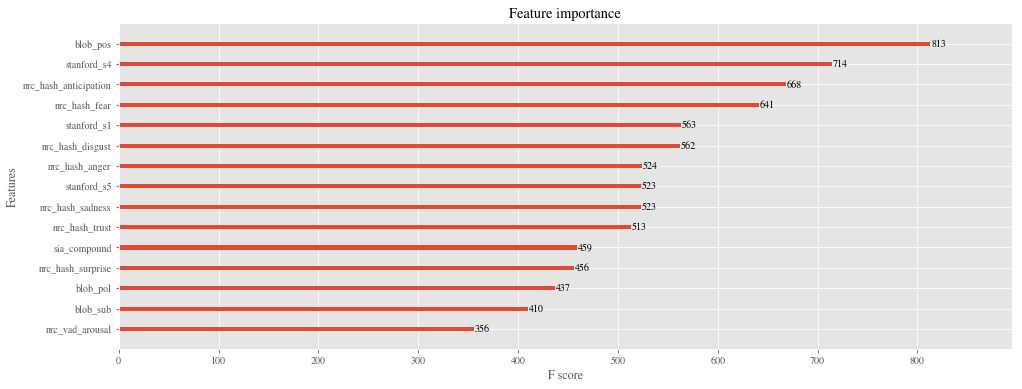

In [439]:
fig, ax = plt.subplots(figsize=(16, 6))
xgb.plot_importance(bst, ax=ax, max_num_features = 15)
plt.show()